In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Installing the numpy, netcdf4, boto3 and gdal libraries
!pip install cartopy netCDF4 boto3
print ('\n')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 73.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 57.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.7/13.7 MB 64.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.2/85.2 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 50.7 MB/s eta 0:00:00


# AERONET


In [ ]:
#@title Dados AERONET - Extrai zip
import os
import zipfile
import pandas as pd
from tqdm import tqdm
import glob
import numpy as np

diretorio_de_extracao = '/content/drive/MyDrive/Meteorologia USP/TCC/Aeronet Dados/'

# Encontrar todos os arquivos .zip no diretório
lista_de_zips = glob.glob(os.path.join(diretorio_de_extracao, '*.zip'))

# Extrair cada arquivo ZIP
for caminho_do_arquivo_zip in lista_de_zips:
    with zipfile.ZipFile(caminho_do_arquivo_zip, 'r') as zip_ref:
        zip_ref.extractall(diretorio_de_extracao)

for i in os.listdir("/content/drive/MyDrive/Meteorologia USP/TCC/Aeronet Dados/"):
  if i.endswith(".zip"):
    os.remove("/content/drive/MyDrive/Meteorologia USP/TCC/Aeronet Dados/"+i)

In [ ]:
#@title Arruma CSV
import os
import zipfile
import pandas as pd
from tqdm import tqdm
import glob
import numpy as np
import re
for arqlev15 in os.listdir("/content/drive/MyDrive/Meteorologia USP/TCC/Aeronet Dados/"):
  if arqlev15.endswith(".lev15"):
    tabela = pd.read_csv('/content/drive/MyDrive/Meteorologia USP/TCC/Aeronet Dados/'+arqlev15, skiprows=6, encoding='latin1')

    colunas_desejadas = [
      'Date(dd:mm:yyyy)', 'Time(hh:mm:ss)', 'Day_of_Year',
      'AOD_1020nm', 'AOD_870nm', 'AOD_675nm', 'AOD_500nm', 'AOD_440nm', 'AOD_380nm',
      'Precipitable_Water(cm)', '440-870_Angstrom_Exponent', '380-500_Angstrom_Exponent',
      '440-675_Angstrom_Exponent', '500-870_Angstrom_Exponent', '340-440_Angstrom_Exponent',
      'Data_Quality_Level', 'AERONET_Instrument_Number', 'AERONET_Site_Name',
      'Site_Latitude(Degrees)', 'Site_Longitude(Degrees)', 'Site_Elevation(m)'
    ]

    tabela.columns = tabela.columns.str.strip()
    colunas_existentes = [col for col in colunas_desejadas if col in tabela.columns]

    tabela = tabela[colunas_existentes].copy()
    print(arqlev15)
    tabela['AOD_550nm'] = tabela['AOD_440nm']*((440/550)**tabela['440-675_Angstrom_Exponent']) #Estima AOD_550 pela formulha do coef. de Angstrom
    tabela = tabela[['Date(dd:mm:yyyy)', 'Time(hh:mm:ss)', 'Day_of_Year','AOD_550nm', 'AOD_1020nm', 'AOD_870nm', 'AOD_675nm', 'AOD_500nm','AOD_440nm', 'AOD_380nm',
        'Precipitable_Water(cm)', '440-870_Angstrom_Exponent', '380-500_Angstrom_Exponent','440-675_Angstrom_Exponent', '500-870_Angstrom_Exponent',
        '340-440_Angstrom_Exponent', 'Data_Quality_Level', 'AERONET_Instrument_Number','AERONET_Site_Name', 'Site_Latitude(Degrees)', 'Site_Longitude(Degrees)', 'Site_Elevation(m)']]

    match = re.search(r'\d{8}_\d{8}_(.*)\.lev15', arqlev15)
    if match:
      nome_arq = match.group(1)
    tabela.to_csv(f'/content/drive/MyDrive/Meteorologia USP/TCC/Aeronet Dados/{nome_arq}.csv', index=False)


20160101_20251231_Cachoeira_Paulista.lev15
20000101_20251231_Sao_Paulo.lev15
20010101_20251231_CUIABA-MIRANDA.lev15
20210101_20251231_Alta_Floresta_IF.lev15
20160101_20251231_SP-EACH.lev15
20060101_20251231_SANTA_CRUZ_UTEPSA.lev15
20060101_20251231_La_Paz.lev15


# GOES-16 PRODUTO AOD

In [ ]:
#@title Teste 1
import xarray as xr
import numpy as np
import pandas as pd
from netCDF4 import Dataset
from pathlib import Path

# Função para calcular lat/lon a partir da projeção do GOES
def calculate_degrees(file_id):
    x_coordinate_1d = file_id.variables['x'][:]
    y_coordinate_1d = file_id.variables['y'][:]
    projection_info = file_id.variables['goes_imager_projection']
    lon_origin = projection_info.longitude_of_projection_origin
    H = projection_info.perspective_point_height + projection_info.semi_major_axis
    r_eq = projection_info.semi_major_axis
    r_pol = projection_info.semi_minor_axis

    x_coordinate_2d, y_coordinate_2d = np.meshgrid(x_coordinate_1d, y_coordinate_1d)

    lambda_0 = (lon_origin * np.pi) / 180.0
    a_var = (np.sin(x_coordinate_2d) ** 2) + (np.cos(x_coordinate_2d) ** 2) * (
        np.cos(y_coordinate_2d) ** 2 + ((r_eq ** 2) / (r_pol ** 2)) * (np.sin(y_coordinate_2d) ** 2)
    )
    b_var = -2.0 * H * np.cos(x_coordinate_2d) * np.cos(y_coordinate_2d)
    c_var = H ** 2 - r_eq ** 2
    r_s = (-b_var - np.sqrt(b_var ** 2 - 4.0 * a_var * c_var)) / (2.0 * a_var)
    s_x = r_s * np.cos(x_coordinate_2d) * np.cos(y_coordinate_2d)
    s_y = -r_s * np.sin(x_coordinate_2d)
    s_z = r_s * np.cos(x_coordinate_2d) * np.sin(y_coordinate_2d)

    np.seterr(all='ignore')

    abi_lat = (180.0 / np.pi) * np.arctan((r_eq ** 2 / r_pol ** 2) * (s_z / np.sqrt((H - s_x) ** 2 + s_y ** 2)))
    abi_lon = (lambda_0 - np.arctan(s_y / (H - s_x))) * (180.0 / np.pi)

    return abi_lat, abi_lon

# Função para encontrar o ponto mais próximo
def find_nearest_latlon(lat_array, lon_array, target_lat, target_lon):
    dist_squared = (lat_array - target_lat) ** 2 + (lon_array - target_lon) ** 2
    idx_flat = np.argmin(dist_squared)
    idx_2d = np.unravel_index(idx_flat, lat_array.shape)
    return int(idx_2d[0]), int(idx_2d[1])

# Caminho para o arquivo
file_name = '/content/drive/MyDrive/Meteorologia USP/TCC/dadosgoesteste/20_08_aodf/OR_ABI-L2-AODF-M6_G16_s20242331800202_e20242331809510_c20242331814287.nc'
file_path = Path(file_name)

# Abrindo com netCDF4 para cálculo de lat/lon
file_id = Dataset(file_path)

# Calculando latitude e longitude
abi_lat, abi_lon = calculate_degrees(file_id)

# Abrindo com xarray para extrair AOD
ds = xr.open_dataset(file_path)
aod = ds['AOD']

# Criando um novo Dataset com lat, lon e AOD
ds_1 = xr.Dataset(
    data_vars={"AOD": (("y", "x"), aod.values)},
    coords={"lat": (("y", "x"), abi_lat), "lon": (("y", "x"), abi_lon)},
    attrs={"description": "AOD com coordenadas 2D do GOES"}
)

# Coordenadas de São Paulo
cidade = 'São Paulo'
target_lat = -23.5615
target_lon = -46.734983

# Encontrando o índice mais próximo
indice = find_nearest_latlon(abi_lat, abi_lon, target_lat, target_lon)

# Extraindo valores
lat_ponto = abi_lat[indice]
lon_ponto = abi_lon[indice]
aod_ponto = ds_1['AOD'][indice].values.item()

# Extraindo a data do nome do arquivo
import re
match = re.search(r's(\d{4})(\d{3})', file_name)
if match:
    ano = match.group(1)
    dia_juliano = match.group(2)
    data = pd.to_datetime(f"{ano}{dia_juliano}", format='%Y%j').strftime('%Y-%m-%d')
else:
    data = 'Desconhecida'

# Criando DataFrame para exportação
df = pd.DataFrame([{
    "Data": data,
    "Cidade": cidade,
    "Latitude": lat_ponto,
    "Longitude": lon_ponto,
    "AOD": aod_ponto
}])

# Mostrando e salvando
print(df)

# Salvando como CSV
#output_csv = '/content/GOES_AOD_SaoPaulo.csv'
#df.to_csv(output_csv, index=False)

#print(f'Arquivo salvo em: {output_csv}')


         Data     Cidade   Latitude  Longitude       AOD
0  2024-08-20  São Paulo -23.559237 -46.744544  0.317576
Arquivo salvo em: /content/GOES_AOD_SaoPaulo.csv


# **Obtendo Arquivos com lat, lon e AOD Goes...**


In [ ]:
#@title Teste Dia 20/08 - 10/09 - Só as ~18h
import os
import boto3
from botocore import UNSIGNED
from botocore.config import Config
from datetime import datetime
import xarray as xr
import numpy as np
import pandas as pd
from netCDF4 import Dataset

def calculate_degrees(file_id):
    x_coordinate_1d = file_id.variables['x'][:]
    y_coordinate_1d = file_id.variables['y'][:]
    projection_info = file_id.variables['goes_imager_projection']
    lon_origin = projection_info.longitude_of_projection_origin
    H = projection_info.perspective_point_height + projection_info.semi_major_axis
    r_eq = projection_info.semi_major_axis
    r_pol = projection_info.semi_minor_axis

    x_coordinate_2d, y_coordinate_2d = np.meshgrid(x_coordinate_1d, y_coordinate_1d)

    lambda_0 = (lon_origin * np.pi) / 180.0
    a_var = (np.sin(x_coordinate_2d) ** 2) + (np.cos(x_coordinate_2d) ** 2) * (
        np.cos(y_coordinate_2d) ** 2 + ((r_eq ** 2) / (r_pol ** 2)) * (np.sin(y_coordinate_2d) ** 2)
    )
    b_var = -2.0 * H * np.cos(x_coordinate_2d) * np.cos(y_coordinate_2d)
    c_var = H ** 2 - r_eq ** 2
    r_s = (-b_var - np.sqrt(b_var ** 2 - 4.0 * a_var * c_var)) / (2.0 * a_var)
    s_x = r_s * np.cos(x_coordinate_2d) * np.cos(y_coordinate_2d)
    s_y = -r_s * np.sin(x_coordinate_2d)
    s_z = r_s * np.cos(x_coordinate_2d) * np.sin(y_coordinate_2d)

    np.seterr(all='ignore')

    abi_lat = (180.0 / np.pi) * np.arctan((r_eq ** 2 / r_pol ** 2) * (s_z / np.sqrt((H - s_x) ** 2 + s_y ** 2)))
    abi_lon = (lambda_0 - np.arctan(s_y / (H - s_x))) * (180.0 / np.pi)

    return abi_lat, abi_lon

def find_nearest_latlon(lat_array, lon_array, target_lat, target_lon):
    dist_squared = (lat_array - target_lat) ** 2 + (lon_array - target_lon) ** 2
    idx_flat = np.argmin(dist_squared)
    idx_2d = np.unravel_index(idx_flat, lat_array.shape)
    return int(idx_2d[0]), int(idx_2d[1])

def download_file(s3_key, local_file):
    try:
        s3.download_file(bucket_name, s3_key, local_file)
        return True
    except Exception as e:
        print(f"Erro ao baixar {s3_key}: {e}")
        return False

input_dir = "./samples"
os.makedirs(input_dir, exist_ok=True)

s3 = boto3.client('s3', config=Config(signature_version=UNSIGNED))
bucket_name = 'noaa-goes16'
product = 'ABI-L2-AODF'  # Usando o AODF

aeronet_city = 'La_Paz'
aeronet_lat = -16.539
aeronet_lon = -68.066467

# Exemplo de leitura do aeronet_data
aeronet_data = pd.read_csv('/content/drive/MyDrive/Meteorologia USP/TCC/Aeronet Dados/La_Paz.csv')

aeronet_data['datetime'] = pd.to_datetime(
    aeronet_data['Date(dd:mm:yyyy)'] + ' ' + aeronet_data['Time(hh:mm:ss)'],
    format='%d:%m:%Y %H:%M:%S'
)
aeronet_data = aeronet_data[aeronet_data['datetime'].dt.year > 2018].copy()
aeronet_data['date'] = aeronet_data['datetime'].dt.date

# Definindo intervalo de datas
start_date = datetime.strptime('2024-08-20', '%Y-%m-%d').date()
end_date = datetime.strptime('2024-09-10', '%Y-%m-%d').date()

results = []

for unique_date in aeronet_data['date'].unique():
    if unique_date < start_date or unique_date > end_date:
        continue  # Pula datas fora do intervalo

    daily_data = aeronet_data[aeronet_data['date'] == unique_date]
    daily_data = daily_data[
        (daily_data['datetime'].dt.hour >= 12) &
        (daily_data['datetime'].dt.hour <= 22)
    ]

    if daily_data.empty:
        continue

    data_18 = daily_data[daily_data['datetime'].dt.hour == 18]

    if not data_18.empty:
        selected_row = data_18.iloc[0]
    else:
        after_18 = daily_data[daily_data['datetime'].dt.hour > 18]
        if not after_18.empty:
            selected_row = after_18.iloc[0]
        else:
            before_18 = daily_data[daily_data['datetime'].dt.hour < 18]
            if not before_18.empty:
                before_18 = before_18.copy()
                before_18['diff'] = abs(before_18['datetime'] - pd.to_datetime(f"{unique_date} 18:00:00"))
                selected_row = before_18.loc[before_18['diff'].idxmin()]
            else:
                continue

    dt = selected_row['datetime']
    y = dt.strftime('%Y')
    j = dt.strftime('%j')
    h = dt.strftime('%H')

    prefix = f"{product}/{y}/{j}/{h}/"

    try:
        response = s3.list_objects_v2(Bucket=bucket_name, Prefix=prefix)
        if 'Contents' not in response:
            print(f"Nenhum arquivo em {prefix}")
            continue

        # Seleciona o PRIMEIRO arquivo
        obj = response['Contents'][0]
        key = obj['Key']
        filename = os.path.join(input_dir, os.path.basename(key))

        if not os.path.exists(filename):
            if not download_file(key, filename):
                continue

        try:
            file_id = Dataset(filename)
            abi_lat, abi_lon = calculate_degrees(file_id)
            file_id.close()

            ds = xr.open_dataset(filename)
            aod = ds['AOD']

            ds_1 = xr.Dataset(
                data_vars={"AOD": (("y", "x"), aod.values)},
                coords={"lat": (("y", "x"), abi_lat), "lon": (("y", "x"), abi_lon)}
            )

            time_str = ds.time_coverage_start
            dt_file = datetime.strptime(time_str, '%Y-%m-%dT%H:%M:%S.%fZ')

            if abs((dt_file - dt).total_seconds()) <= 600:
                try:
                    idx = find_nearest_latlon(abi_lat, abi_lon, aeronet_lat, aeronet_lon)
                    lat_val = abi_lat[idx]
                    lon_val = abi_lon[idx]
                    aod_val = ds_1['AOD'][idx].values.item()

                    results.append({
                        'cidade': aeronet_city,
                        'data_aeronet': dt.strftime('%Y-%m-%d'),
                        'hora_aeronet': dt.strftime('%H:%M:%S'),
                        'data_goes': dt_file.strftime('%Y-%m-%d'),
                        'hora_goes': dt_file.strftime('%H:%M:%S'),
                        'lat': lat_val,
                        'lon': lon_val,
                        'aod': aod_val
                    })

                except Exception as e:
                    print(f"Erro extraindo AOD: {e}")

            ds.close()

        except Exception as e:
            print(f"Erro ao processar arquivo {filename}: {e}")
        finally:
            if os.path.exists(filename):
                os.remove(filename)

    except Exception as e:
        print(f"Erro ao processar {prefix}: {e}")

df_results = pd.DataFrame(results)
df_results.to_csv('/content/drive/MyDrive/Meteorologia USP/TCC/GOES16 Produto AOD/AOD_GOES16_18h_LaPaz.csv', index=False)
print("Arquivo salvo: AOD_GOES16_18h_LaPaz.csv")


Arquivo salvo: AOD_GOES16_18h_LaPaz.csv


In [ ]:
#@title Diario Hora a Hora (20/08 - 10/09/24)
import os
import boto3
from botocore import UNSIGNED
from botocore.config import Config
from datetime import datetime, timedelta
import xarray as xr
import numpy as np
import pandas as pd
from netCDF4 import Dataset

# Função para calcular degrees
def calculate_degrees(file_id):
    x_coordinate_1d = file_id.variables['x'][:]
    y_coordinate_1d = file_id.variables['y'][:]
    projection_info = file_id.variables['goes_imager_projection']
    lon_origin = projection_info.longitude_of_projection_origin
    H = projection_info.perspective_point_height + projection_info.semi_major_axis
    r_eq = projection_info.semi_major_axis
    r_pol = projection_info.semi_minor_axis

    x_coordinate_2d, y_coordinate_2d = np.meshgrid(x_coordinate_1d, y_coordinate_1d)

    lambda_0 = (lon_origin * np.pi) / 180.0
    a_var = (np.sin(x_coordinate_2d) ** 2) + (np.cos(x_coordinate_2d) ** 2) * (
        np.cos(y_coordinate_2d) ** 2 + ((r_eq ** 2) / (r_pol ** 2)) * (np.sin(y_coordinate_2d) ** 2)
    )
    b_var = -2.0 * H * np.cos(x_coordinate_2d) * np.cos(y_coordinate_2d)
    c_var = H ** 2 - r_eq ** 2
    r_s = (-b_var - np.sqrt(b_var ** 2 - 4.0 * a_var * c_var)) / (2.0 * a_var)
    s_x = r_s * np.cos(x_coordinate_2d) * np.cos(y_coordinate_2d)
    s_y = -r_s * np.sin(x_coordinate_2d)
    s_z = r_s * np.cos(x_coordinate_2d) * np.sin(y_coordinate_2d)

    np.seterr(all='ignore')

    abi_lat = (180.0 / np.pi) * np.arctan((r_eq ** 2 / r_pol ** 2) * (s_z / np.sqrt((H - s_x) ** 2 + s_y ** 2)))
    abi_lon = (lambda_0 - np.arctan(s_y / (H - s_x))) * (180.0 / np.pi)

    return abi_lat, abi_lon

# Função para encontrar o pixel mais próximo
def find_nearest_point(lat_array, lon_array, target_lat, target_lon):
    dist_squared = (lat_array - target_lat)**2 + (lon_array - target_lon)**2
    idx_flat = np.argmin(dist_squared)
    return np.unravel_index(idx_flat, lat_array.shape)

# Função para baixar arquivo
def download_file(s3, bucket_name, s3_key, local_file):
    try:
        s3.download_file(bucket_name, s3_key, local_file)
        return True
    except Exception as e:
        print(f"Erro ao baixar {s3_key}: {e}")
        return False

# Configurações iniciais
input_dir = "./samples"
os.makedirs(input_dir, exist_ok=True)

s3 = boto3.client('s3', config=Config(signature_version=UNSIGNED))
bucket_name = 'noaa-goes16'
product = 'ABI-L2-AODF'

aeronet_city = 'Sao_Paulo'
aeronet_lat = -23.5505
aeronet_lon = -46.6333

# Exemplo de leitura do aeronet_data
aeronet_data = pd.read_csv('/content/drive/MyDrive/Meteorologia USP/TCC/Aeronet Dados/Sao_Paulo.csv')

aeronet_data['datetime'] = pd.to_datetime(
    aeronet_data['Date(dd:mm:yyyy)'] + ' ' + aeronet_data['Time(hh:mm:ss)'],
    format='%d:%m:%Y %H:%M:%S'
)
aeronet_data = aeronet_data[aeronet_data['datetime'].dt.year > 2023].copy()
aeronet_data['date'] = aeronet_data['datetime'].dt.date

# Intervalo de datas
start_date = datetime.strptime('2024-08-20', '%Y-%m-%d').date()
end_date = datetime.strptime('2024-09-10', '%Y-%m-%d').date()

results = []

# Para cada dia
for unique_date in aeronet_data['date'].unique():
    if unique_date < start_date or unique_date > end_date:
        continue

    daily_data = aeronet_data[aeronet_data['date'] == unique_date]
    # Filtrar entre 06h e 23h
    daily_data = daily_data[
        (daily_data['datetime'].dt.hour >= 6) &
        (daily_data['datetime'].dt.hour <= 23)
    ]

    if daily_data.empty:
        continue

    # Para cada hora desejada (exemplo: 12, 13, 14, ..., 22)
    for hour in range(06, 23):
        # Selecionar a leitura mais próxima dessa hora
        hora_obj = pd.to_datetime(f"{unique_date} {hour}:00:00")
        # Encontrar a leitura mais próxima ao horário exato
        daily_data['diff'] = abs(daily_data['datetime'] - hora_obj)
        selected_row = daily_data.loc[daily_data['diff'].idxmin()]

        dt = selected_row['datetime']
        y = dt.strftime('%Y')
        j = dt.strftime('%j')
        h = dt.strftime('%H')

        prefix = f"{product}/{y}/{j}/{h}/"

        try:
            response = s3.list_objects_v2(Bucket=bucket_name, Prefix=prefix)
            if 'Contents' not in response:
                print(f"Nenhum arquivo em {prefix}")
                continue

            # Seleciona o primeiro arquivo (pode ajustar para o mais recente se necessário)
            obj = response['Contents'][0]
            key = obj['Key']
            filename = os.path.join(input_dir, os.path.basename(key))

            if not os.path.exists(filename):
                if not download_file(s3, bucket_name, key, filename):
                    continue

            # Abrir o arquivo netCDF
            with Dataset(filename) as file_id:
                abi_lat, abi_lon = calculate_degrees(file_id)

            # Abrir o dataset xarray
            ds = xr.open_dataset(filename)
            aod = ds['AOD']

            # Selecionar o pixel mais próximo de São Paulo
            idx = find_nearest_point(abi_lat, abi_lon, aeronet_lat, aeronet_lon)
            lat_val = abi_lat[idx]
            lon_val = abi_lon[idx]
            aod_val = ds['AOD'][idx].values.item()

            # Verificar se o horário do arquivo está próximo do aeronet
            time_str = ds.time_coverage_start
            dt_file = datetime.strptime(time_str, '%Y-%m-%dT%H:%M:%S.%fZ')
            if abs((dt_file - dt).total_seconds()) <= 600:
                results.append({
                    'cidade': aeronet_city,
                    'data_aeronet': dt.strftime('%Y-%m-%d'),
                    'hora_aeronet': dt.strftime('%H:%M:%S'),
                    'data_goes': dt_file.strftime('%Y-%m-%d'),
                    'hora_goes': dt_file.strftime('%H:%M:%S'),
                    'lat': lat_val,
                    'lon': lon_val,
                    'aod': aod_val
                })

            ds.close()

            # Remover arquivo para economia de espaço
            if os.path.exists(filename):
                os.remove(filename)

        except Exception as e:
            print(f"Erro ao processar arquivo {filename}: {e}")

# Salvar resultados
df_results = pd.DataFrame(results)
df_results.to_csv('/content/drive/MyDrive/Meteorologia USP/TCC/GOES16 Produto AOD/AOD_GOES16_Sao_Paulo_1.csv', index=False)
print("Arquivo salvo: AOD_GOES16_Sao_Paulo_1.csv")


In [ ]:
#@title Download dados no samples
import os
import boto3
from botocore import UNSIGNED
from botocore.config import Config
from datetime import datetime

# Função para baixar arquivo
def download_file(s3, bucket_name, s3_key, local_file):
    try:
        s3.download_file(bucket_name, s3_key, local_file)
        print(f"Baixado: {local_file}")
        return True
    except Exception as e:
        print(f"Erro ao baixar {s3_key}: {e}")
        return False

# Configurações iniciais
input_dir = "./samples"
os.makedirs(input_dir, exist_ok=True)

s3 = boto3.client('s3', config=Config(signature_version=UNSIGNED))
bucket_name = 'noaa-goes16'
product = 'ABI-L2-AODF'

# Intervalo de datas
start_date = datetime.strptime('2024-08-20', '%Y-%m-%d').date()
end_date = datetime.strptime('2024-09-10', '%Y-%m-%d').date()

# Para cada dia e hora
current_date = start_date
while current_date <= end_date:
    y = current_date.strftime('%Y')
    j = current_date.strftime('%j')

    for h in range(6, 24):  # de 06h a 23h
        prefix = f"{product}/{y}/{j}/{h:02d}/"

        try:
            response = s3.list_objects_v2(Bucket=bucket_name, Prefix=prefix)
            if 'Contents' not in response:
                print(f"Nenhum arquivo em {prefix}")
                continue

            for obj in response['Contents']:
                key = obj['Key']
                filename = os.path.join(input_dir, os.path.basename(key))

                if not os.path.exists(filename):
                    download_file(s3, bucket_name, key, filename)

        except Exception as e:
            print(f"Erro ao processar prefixo {prefix}: {e}")

    current_date += timedelta(days=1)

print("Download concluído.")


In [ ]:
#@title Processamento e Correlação AERONET-GOES (10 min) - AOD550 + AOD GOES
import numpy as np
import xarray as xr
import pandas as pd
import os
from netCDF4 import Dataset
from datetime import datetime, timedelta

# === Função para calcular latitude e longitude ===
def calculate_degrees(file_id):
    x_coordinate_1d = file_id.variables['x'][:]
    y_coordinate_1d = file_id.variables['y'][:]
    projection_info = file_id.variables['goes_imager_projection']

    lon_origin = projection_info.longitude_of_projection_origin
    H = projection_info.perspective_point_height + projection_info.semi_major_axis
    r_eq = projection_info.semi_major_axis
    r_pol = projection_info.semi_minor_axis

    x_coordinate_2d, y_coordinate_2d = np.meshgrid(x_coordinate_1d, y_coordinate_1d)
    lambda_0 = np.deg2rad(lon_origin)

    a_var = (np.sin(x_coordinate_2d) ** 2) + (np.cos(x_coordinate_2d) ** 2) * (
        np.cos(y_coordinate_2d) ** 2 + ((r_eq ** 2) / (r_pol ** 2)) * (np.sin(y_coordinate_2d) ** 2)
    )
    b_var = -2.0 * H * np.cos(x_coordinate_2d) * np.cos(y_coordinate_2d)
    c_var = H ** 2 - r_eq ** 2

    r_s = (-b_var - np.sqrt(b_var ** 2 - 4.0 * a_var * c_var)) / (2.0 * a_var)
    s_x = r_s * np.cos(x_coordinate_2d) * np.cos(y_coordinate_2d)
    s_y = -r_s * np.sin(x_coordinate_2d)
    s_z = r_s * np.cos(x_coordinate_2d) * np.sin(y_coordinate_2d)

    abi_lat = np.rad2deg(np.arctan((r_eq ** 2 / r_pol ** 2) * (s_z / np.sqrt((H - s_x) ** 2 + s_y ** 2))))
    abi_lon = np.rad2deg(lambda_0 - np.arctan(s_y / (H - s_x)))

    return abi_lat, abi_lon

# === Função para encontrar o pixel mais próximo ===
def find_nearest_point(lat_array, lon_array, target_lat, target_lon):
    dist_squared = (lat_array - target_lat) ** 2 + (lon_array - target_lon) ** 2
    idx_flat = np.argmin(dist_squared)
    return np.unravel_index(idx_flat, lat_array.shape)

# === Localização da estação AERONET ===
aeronet_city = 'Sao_Paulo'
aeronet_lat = -23.5505
aeronet_lon = -46.6333

# === Pasta onde estão os arquivos GOES ===
samples_dir = '/content/samples'

# === Leitura do arquivo AERONET ===
aeronet_columns = [
    'Date', 'Time', 'Day_of_Year', 'AOD_550nm', 'AOD_675nm', 'AOD_870nm',
    'AOD_1020nm', 'AOD_440nm', 'AOD_500nm', 'AOD_340nm', 'Precipitable_Water',
    'Angstrom_440_870', 'Angstrom_380_500', 'Angstrom_440_675', 'Angstrom_500_870',
    'Angstrom_340_440', 'Data_Quality', 'Julian_Day', 'Site', 'Site_Latitude',
    'Site_Longitude', 'Site_Elevation'
]

try:
    aeronet_data = pd.read_csv(
        '/content/drive/MyDrive/Meteorologia USP/TCC/Aeronet Dados/Sao_Paulo.csv',
        skiprows=6,
        na_values=['N/A'],
        names=aeronet_columns,
        header=None
    )
except FileNotFoundError:
    print("Erro: Arquivo AERONET não encontrado. Verifique o caminho.")
    raise

# Combinar data e hora
try:
    aeronet_data['datetime'] = pd.to_datetime(
        aeronet_data['Date'] + ' ' + aeronet_data['Time'],
        format='%d:%m:%Y %H:%M:%S'
    )
except (KeyError, ValueError) as e:
    print(f"Erro ao processar data/hora: {e}")
    raise

# Verificar coluna AOD
aod_column = 'AOD_550nm'
if aod_column not in aeronet_data.columns:
    possible_aod_columns = [col for col in aeronet_data.columns if '550' in col]
    if possible_aod_columns:
        aod_column = possible_aod_columns[0]
        print(f"Usando a coluna de AOD: {aod_column}")
    else:
        raise KeyError("Nenhuma coluna de AOD 550nm encontrada.")

# Filtrar AERONET para 20/08/2024 a 10/09/2024
aeronet_data = aeronet_data[
    (aeronet_data['datetime'] >= '2024-08-20 00:00:00') &
    (aeronet_data['datetime'] <= '2024-09-10 23:59:59')
]

if aeronet_data.empty:
    print("Nenhum dado AERONET encontrado para 20/08/2024 a 10/09/2024.")
    raise ValueError("Sem dados AERONET no período.")

# === Identificar arquivos GOES ===
try:
    all_files = [f for f in os.listdir(samples_dir) if f.endswith('.nc')]
except Exception as e:
    print(f"Erro ao listar arquivos em {samples_dir}: {e}")
    all_files = []

# Filtrar arquivos GOES para 20/08/2024 a 10/09/2024
goes_files = []
start_date = datetime(2024, 8, 20)
end_date = datetime(2024, 9, 10)
for f in all_files:
    try:
        parts = f.split('_')
        for p in parts:
            if p.startswith('s'):
                goes_dt = datetime.strptime(p[1:13], '%Y%j%H%M%S')
                if start_date.date() <= goes_dt.date() <= end_date.date():
                    goes_files.append((f, goes_dt))
                break
    except:
        continue

if not goes_files:
    print("Nenhum arquivo GOES encontrado para 20/08/2024 a 10/09/2024.")
    raise ValueError("Sem arquivos GOES no período.")

# Criar conjunto de arquivos GOES já processados
processed_goes_files = set()
results = []

# === Processar medições AERONET ===
for _, aeronet_row in aeronet_data.iterrows():
    aeronet_time = aeronet_row['datetime']
    aod_550 = aeronet_row[aod_column]

    # Encontrar arquivo GOES mais próximo com diferença <= 1 minutos
    min_diff = timedelta(minutes=1)
    best_file = None
    best_goes_dt = None

    for goes_file, goes_dt in goes_files:
        if goes_file in processed_goes_files:
            continue

        time_diff = abs(aeronet_time - goes_dt)
        if time_diff <= min_diff:
            min_diff = time_diff
            best_file = goes_file
            best_goes_dt = goes_dt

    if best_file is None:
        print(f"Nenhum arquivo GOES encontrado dentro de 1 minutos para AERONET {aeronet_time}")
        continue

    # Marcar arquivo GOES como processado
    processed_goes_files.add(best_file)

    # Verificar se o arquivo GOES existe
    filepath = os.path.join(samples_dir, best_file)
    if not os.path.exists(filepath):
        print(f"Arquivo GOES não encontrado: {filepath}")
        continue

    # === Processar o arquivo GOES ===
    try:
        with Dataset(filepath, 'r') as file_id:
            abi_lat, abi_lon = calculate_degrees(file_id)

        ds = xr.open_dataset(filepath)

        if 'AOD' not in ds.variables:
            print(f"Variável 'AOD' não encontrada em {best_file}")
            ds.close()
            continue

        aod = ds['AOD']
        idx = find_nearest_point(abi_lat, abi_lon, aeronet_lat, aeronet_lon)
        lat_val = abi_lat[idx]
        lon_val = abi_lon[idx]
        aod_val = float(aod[idx].values)

        time_str = ds.attrs.get('time_coverage_start', None)
        if time_str:
            dt_file = datetime.strptime(time_str, '%Y-%m-%dT%H:%M:%S.%fZ')
        else:
            dt_file = best_goes_dt

        ds.close()

        results.append({
            'cidade': aeronet_city,
            'data_aeronet': aeronet_time.strftime('%Y-%m-%d'),
            'hora_aeronet': aeronet_time.strftime('%H:%M:%S'),
            'AOD_550nm': aod_550,
            'data_goes': dt_file.strftime('%Y-%m-%d'),
            'hora_goes': dt_file.strftime('%H:%M:%S'),
            'lat': lat_val,
            'lon': lon_val,
            'aod_goes': aod_val
        })

        print(f"Processado AERONET {aeronet_time} com GOES {best_file}")

    except Exception as e:
        print(f"Erro ao processar {filepath}: {e}")

# === Salvar resultado ===
if results:
    df_results = pd.DataFrame(results)
    output_csv = '/content/drive/MyDrive/Meteorologia USP/TCC/GOES16 Produto AOD/AOD_GOES16_Sao_Paulo_final.csv'
    df_results.to_csv(output_csv, index=False)
    print(f"Arquivo salvo: {output_csv}")
else:
    print("Nenhum resultado gerado.")

In [ ]:
import os
samples_dir = '/content/samples'
print("Arquivos em /content/samples:", os.listdir(samples_dir))

Arquivos em /content/samples: ['OR_ABI-L2-AODF-M6_G16_s20242401640206_e20242401649514_c20242401654313.nc', 'OR_ABI-L2-AODF-M6_G16_s20242360740205_e20242360749513_c20242360754248.nc', 'OR_ABI-L2-AODF-M6_G16_s20242441040207_e20242441049515_c20242441054297.nc', 'OR_ABI-L2-AODF-M6_G16_s20242330830204_e20242330839512_c20242330844275.nc', 'OR_ABI-L2-AODF-M6_G16_s20242421130206_e20242421139514_c20242421144345.nc', 'OR_ABI-L2-AODF-M6_G16_s20242442050205_e20242442059513_c20242442104312.nc', 'OR_ABI-L2-AODF-M6_G16_s20242510630206_e20242510639514_c20242510644322.nc', 'OR_ABI-L2-AODF-M6_G16_s20242440930207_e20242440939515_c20242440944275.nc', 'OR_ABI-L2-AODF-M6_G16_s20242450630207_e20242450639515_c20242450644227.nc', 'OR_ABI-L2-AODF-M6_G16_s20242331440205_e20242331449513_c20242331454285.nc', 'OR_ABI-L2-AODF-M6_G16_s20242501310206_e20242501319514_c20242501324368.nc', 'OR_ABI-L2-AODF-M6_G16_s20242381920203_e20242381929511_c20242381934307.nc', 'OR_ABI-L2-AODF-M6_G16_s20242441750205_e20242441759513_c2

In [ ]:
#@title Ano 2024
import os
import boto3
from botocore import UNSIGNED
from botocore.config import Config
from datetime import datetime
import xarray as xr
import numpy as np
import pandas as pd
from netCDF4 import Dataset

def calculate_degrees(file_id):
    x_coordinate_1d = file_id.variables['x'][:]
    y_coordinate_1d = file_id.variables['y'][:]
    projection_info = file_id.variables['goes_imager_projection']
    lon_origin = projection_info.longitude_of_projection_origin
    H = projection_info.perspective_point_height + projection_info.semi_major_axis
    r_eq = projection_info.semi_major_axis
    r_pol = projection_info.semi_minor_axis

    x_coordinate_2d, y_coordinate_2d = np.meshgrid(x_coordinate_1d, y_coordinate_1d)

    lambda_0 = (lon_origin * np.pi) / 180.0
    a_var = (np.sin(x_coordinate_2d) ** 2) + (np.cos(x_coordinate_2d) ** 2) * (
        np.cos(y_coordinate_2d) ** 2 + ((r_eq ** 2) / (r_pol ** 2)) * (np.sin(y_coordinate_2d) ** 2)
    )
    b_var = -2.0 * H * np.cos(x_coordinate_2d) * np.cos(y_coordinate_2d)
    c_var = H ** 2 - r_eq ** 2
    r_s = (-b_var - np.sqrt(b_var ** 2 - 4.0 * a_var * c_var)) / (2.0 * a_var)
    s_x = r_s * np.cos(x_coordinate_2d) * np.cos(y_coordinate_2d)
    s_y = -r_s * np.sin(x_coordinate_2d)
    s_z = r_s * np.cos(x_coordinate_2d) * np.sin(y_coordinate_2d)

    np.seterr(all='ignore')

    abi_lat = (180.0 / np.pi) * np.arctan((r_eq ** 2 / r_pol ** 2) * (s_z / np.sqrt((H - s_x) ** 2 + s_y ** 2)))
    abi_lon = (lambda_0 - np.arctan(s_y / (H - s_x))) * (180.0 / np.pi)

    return abi_lat, abi_lon

def find_nearest_latlon(lat_array, lon_array, target_lat, target_lon):
    dist_squared = (lat_array - target_lat) ** 2 + (lon_array - target_lon) ** 2
    idx_flat = np.argmin(dist_squared)
    idx_2d = np.unravel_index(idx_flat, lat_array.shape)
    return int(idx_2d[0]), int(idx_2d[1])

def download_file(s3_key, local_file):
    try:
        s3.download_file(bucket_name, s3_key, local_file)
        return True
    except Exception as e:
        print(f"Erro ao baixar {s3_key}: {e}")
        return False

input_dir = "./samples"
os.makedirs(input_dir, exist_ok=True)

s3 = boto3.client('s3', config=Config(signature_version=UNSIGNED))
bucket_name = 'noaa-goes16'
product = 'ABI-L2-AODF'  # Usando o AODF

aeronet_city = 'Sao_Paulo'
aeronet_lat = -23.5505
aeronet_lon = -46.6333

# Exemplo de leitura do aeronet_data
aeronet_data = pd.read_csv('/content/drive/MyDrive/Meteorologia USP/TCC/Aeronet Dados/Sao_Paulo.csv')

aeronet_data['datetime'] = pd.to_datetime(
    aeronet_data['Date(dd:mm:yyyy)'] + ' ' + aeronet_data['Time(hh:mm:ss)'],
    format='%d:%m:%Y %H:%M:%S'
)
aeronet_data = aeronet_data[aeronet_data['datetime'].dt.year == 2024].copy()
aeronet_data['date'] = aeronet_data['datetime'].dt.date

results = []

for unique_date in aeronet_data['date'].unique():
    daily_data = aeronet_data[aeronet_data['date'] == unique_date]
    daily_data = daily_data[
        (daily_data['datetime'].dt.hour >= 12) &
        (daily_data['datetime'].dt.hour <= 22)
    ]

    if daily_data.empty:
        continue

    data_18 = daily_data[daily_data['datetime'].dt.hour == 18]

    if not data_18.empty:
        selected_row = data_18.iloc[0]
    else:
        after_18 = daily_data[daily_data['datetime'].dt.hour > 18]
        if not after_18.empty:
            selected_row = after_18.iloc[0]
        else:
            before_18 = daily_data[daily_data['datetime'].dt.hour < 18]
            if not before_18.empty:
                before_18 = before_18.copy()
                before_18['diff'] = abs(before_18['datetime'] - pd.to_datetime(f"{unique_date} 18:00:00"))
                selected_row = before_18.loc[before_18['diff'].idxmin()]
            else:
                continue

    dt = selected_row['datetime']
    y = dt.strftime('%Y')
    j = dt.strftime('%j')
    h = dt.strftime('%H')

    prefix = f"{product}/{y}/{j}/{h}/"

    try:
        response = s3.list_objects_v2(Bucket=bucket_name, Prefix=prefix)
        if 'Contents' not in response:
            print(f"Nenhum arquivo em {prefix}")
            continue

        # Seleciona o PRIMEIRO arquivo da lista
        obj = response['Contents'][0]
        key = obj['Key']
        filename = os.path.join(input_dir, os.path.basename(key))

        if not os.path.exists(filename):
            if not download_file(key, filename):
                continue

        try:
            total_var = ['AOD', 'DQF', 't', 'y', 'x', 'time_bounds', 'goes_imager_projection', 'y_image', 'y_image_bounds', 'x_image', 'x_image_bounds', 'nominal_satellite_subpoint_lat', 'nominal_satellite_subpoint_lon', 'nominal_satellite_height', 'geospatial_lat_lon_extent', 'sunglint_angle', 'sunglint_angle_bounds', 'retrieval_local_zenith_angle', 'quantitative_local_zenith_angle', 'retrieval_local_zenith_angle_bounds', 'quantitative_local_zenith_angle_bounds', 'retrieval_solar_zenith_angle', 'quantitative_solar_zenith_angle', 'retrieval_solar_zenith_angle_bounds', 'quantitative_solar_zenith_angle_bounds', 'aod_product_wavelength', 'land_sensor_band_wavelengths', 'sea_sensor_band_wavelengths', 'land_sensor_band_ids', 'sea_sensor_band_ids', 'latitude_bands', 'latitude_band_bounds', 'snow_free_land_and_ice_free_sea', 'goes_lat_lon_projection', 'aod550_retrievals_attempted_land', 'aod550_retrievals_attempted_sea', 'aod550_good_LZA_retrievals_attempted', 'aod550_outlier_pixel_count', 'min_aod550_land', 'max_aod550_land', 'mean_aod550_land', 'std_dev_aod550_land', 'min_aod550_sea', 'max_aod550_sea', 'mean_aod550_sea', 'std_dev_aod550_sea', 'algorithm_dynamic_input_data_container', 'processing_parm_version_container', 'algorithm_product_version_container', 'lat_band_aod550_retrievals_attempted_land', 'lat_band_aod550_retrievals_attempted_sea', 'lat_band_aod550_good_LZA_retrievals_attempted_land', 'lat_band_aod550_good_LZA_retrievals_attempted_sea', 'lat_band_aod550_percent_high_quality_retrievals_land', 'lat_band_aod550_percent_medium_quality_retrievals_land', 'lat_band_aod550_percent_low_quality_retrievals_land', 'lat_band_aod550_percent_no_retrievals_land', 'lat_band_aod550_percent_high_quality_retrievals_sea', 'lat_band_aod550_percent_medium_quality_retrievals_sea', 'lat_band_aod550_percent_low_quality_retrievals_sea', 'lat_band_aod550_percent_no_retrievals_sea', 'lat_band_min_aod550_land', 'lat_band_max_aod550_land', 'lat_band_mean_aod550_land', 'lat_band_std_dev_aod550_land', 'lat_band_min_aod550_sea', 'lat_band_max_aod550_sea', 'lat_band_mean_aod550_sea', 'lat_band_std_dev_aod550_sea', 'percent_uncorrectable_GRB_errors', 'percent_uncorrectable_L0_errors']
            select_var = ['AOD', 'x','y','goes_imager_projection']
            drop_vars = [var for var in total_var if not var in select_var]

            file_id = Dataset(filename,drop_variables=drop_vars)
            # file_id = Dataset(filename)
            abi_lat, abi_lon = calculate_degrees(file_id)
            file_id.close()

            ds = xr.open_dataset(filename)
            aod = ds['AOD']

            ds_1 = xr.Dataset(
                data_vars={"AOD": (("y", "x"), aod.values)},
                coords={"lat": (("y", "x"), abi_lat), "lon": (("y", "x"), abi_lon)}
            )

            time_str = ds.time_coverage_start
            dt_file = datetime.strptime(time_str, '%Y-%m-%dT%H:%M:%S.%fZ')

            if abs((dt_file - dt).total_seconds()) <= 600:
                try:
                    idx = find_nearest_latlon(abi_lat, abi_lon, aeronet_lat, aeronet_lon)
                    lat_val = abi_lat[idx]
                    lon_val = abi_lon[idx]
                    aod_val = ds_1['AOD'][idx].values.item()

                    results.append({
                        'cidade': aeronet_city,
                        'data_aeronet': dt.strftime('%Y-%m-%d'),
                        'hora_aeronet': dt.strftime('%H:%M:%S'),
                        'data_goes': dt_file.strftime('%Y-%m-%d'),
                        'hora_goes': dt_file.strftime('%H:%M:%S'),
                        'lat': lat_val,
                        'lon': lon_val,
                        'aod': aod_val
                    })

                except Exception as e:
                    print(f"Erro extraindo AOD: {e}")

            ds.close()

        except Exception as e:
            print(f"Erro ao processar arquivo {filename}: {e}")
        finally:
            if os.path.exists(filename):
                os.remove(filename)

    except Exception as e:
        print(f"Erro ao processar {prefix}: {e}")

df_results = pd.DataFrame(results)
df_results.to_csv('/content/drive/MyDrive/Meteorologia USP/TCC/GOES16 Produto AOD/AOD_GOES16_2024x_Sao_Paulo.csv', index=False)
print("Arquivo salvo: AOD_GOES16_SP_2024x.csv")


<ipython-input-3-6d1dffe79ab7>:29: RuntimeWarning: invalid value encountered in sqrt
  r_s = (-b_var - np.sqrt(b_var ** 2 - 4.0 * a_var * c_var)) / (2.0 * a_var)


Nenhum arquivo em ABI-L2-AODF/2024/080/18/
Nenhum arquivo em ABI-L2-AODF/2024/253/18/
Nenhum arquivo em ABI-L2-AODF/2024/272/15/
Arquivo salvo: AOD_GOES16_SP_2024x.csv


In [ ]:
#@title Teste inicial
import os
import boto3
from botocore import UNSIGNED
from botocore.config import Config
from datetime import datetime, timedelta
import xarray as xr
import numpy as np
import pandas as pd
from netCDF4 import Dataset
import re

# Função para calcular lat/lon a partir da projeção do GOES
def calculate_degrees(file_id):
    x_coordinate_1d = file_id.variables['x'][:]
    y_coordinate_1d = file_id.variables['y'][:]
    projection_info = file_id.variables['goes_imager_projection']
    lon_origin = projection_info.longitude_of_projection_origin
    H = projection_info.perspective_point_height + projection_info.semi_major_axis
    r_eq = projection_info.semi_major_axis
    r_pol = projection_info.semi_minor_axis

    x_coordinate_2d, y_coordinate_2d = np.meshgrid(x_coordinate_1d, y_coordinate_1d)

    lambda_0 = (lon_origin * np.pi) / 180.0
    a_var = (np.sin(x_coordinate_2d) ** 2) + (np.cos(x_coordinate_2d) ** 2) * (
        np.cos(y_coordinate_2d) ** 2 + ((r_eq ** 2) / (r_pol ** 2)) * (np.sin(y_coordinate_2d) ** 2)
    )
    b_var = -2.0 * H * np.cos(x_coordinate_2d) * np.cos(y_coordinate_2d)
    c_var = H ** 2 - r_eq ** 2
    r_s = (-b_var - np.sqrt(b_var ** 2 - 4.0 * a_var * c_var)) / (2.0 * a_var)
    s_x = r_s * np.cos(x_coordinate_2d) * np.cos(y_coordinate_2d)
    s_y = -r_s * np.sin(x_coordinate_2d)
    s_z = r_s * np.cos(x_coordinate_2d) * np.sin(y_coordinate_2d)

    np.seterr(all='ignore')

    abi_lat = (180.0 / np.pi) * np.arctan((r_eq ** 2 / r_pol ** 2) * (s_z / np.sqrt((H - s_x) ** 2 + s_y ** 2)))
    abi_lon = (lambda_0 - np.arctan(s_y / (H - s_x))) * (180.0 / np.pi)

    return abi_lat, abi_lon

# Função para encontrar o ponto mais próximo
def find_nearest_latlon(lat_array, lon_array, target_lat, target_lon):
    dist_squared = (lat_array - target_lat) ** 2 + (lon_array - target_lon) ** 2
    idx_flat = np.argmin(dist_squared)
    idx_2d = np.unravel_index(idx_flat, lat_array.shape)
    return int(idx_2d[0]), int(idx_2d[1])

# Diretórios
input_dir = "./samples"
os.makedirs(input_dir, exist_ok=True)

# Intervalo de datas
start_date = datetime(2024, 8, 20)
end_date = datetime(2024, 9, 10)

# Horários desejados
hours = list(range(8, 23))  # das 08h até 22h

# Bucket AWS GOES-16
s3 = boto3.client('s3', config=Config(signature_version=UNSIGNED))
bucket_name = 'noaa-goes16'

# Produto AOD
product = 'ABI-L2-AODF'

# Cidades e coordenadas
cities = {
    'São_Paulo': (-23.5505, -46.6333),
    'Cuiaba-Miranda': (-15.73091, -56.07086),
    'Alta-Floresta': (-9.908354, -56.064393),
    'La-Paz': (-16.539, -68.066467)
}

# Função para baixar arquivo
def download_file(s3_key, local_file):
    try:
        s3.download_file(bucket_name, s3_key, local_file)
        return True
    except Exception as e:
        print(f"Erro ao baixar {s3_key}: {e}")
        return False

# DataFrames para cada cidade
city_data = {city: [] for city in cities}

# Loop principal
current_date = start_date
while current_date <= end_date:
    y = current_date.strftime('%Y')
    j = current_date.strftime('%j')  # dia juliano
    for h in hours:
        hh = f"{h:02d}"
        prefix = f"{product}/{y}/{j}/{hh}/"
        try:
            response = s3.list_objects_v2(Bucket=bucket_name, Prefix=prefix)
            if 'Contents' not in response:
                print(f"Nenhum arquivo em {prefix}")
                continue

            for obj in response['Contents']:
                key = obj['Key']
                filename = os.path.join(input_dir, os.path.basename(key))
                if not os.path.exists(filename):
                    if not download_file(key, filename):
                        continue

                try:
                    file_id = Dataset(filename)
                    abi_lat, abi_lon = calculate_degrees(file_id)
                    file_id.close()

                    ds = xr.open_dataset(filename)
                    aod = ds['AOD']

                    ds_1 = xr.Dataset(
                        data_vars={"AOD": (("y", "x"), aod.values)},
                        coords={"lat": (("y", "x"), abi_lat), "lon": (("y", "x"), abi_lon)}
                    )

                    # Tempo
                    time_str = ds.time_coverage_start
                    dt = datetime.strptime(time_str, '%Y-%m-%dT%H:%M:%S.%fZ')
                    date_str = dt.strftime('%Y-%m-%d')
                    time_only = dt.strftime('%H:%M:%S')

                    for city, (lat_p, lon_p) in cities.items():
                        try:
                            idx = find_nearest_latlon(abi_lat, abi_lon, lat_p, lon_p)
                            lat_val = abi_lat[idx]
                            lon_val = abi_lon[idx]
                            aod_val = ds_1['AOD'][idx].values.item()

                            city_data[city].append({
                                'cidade': city,
                                'data': date_str,
                                'hora': time_only,
                                'lat': lat_val,
                                'lon': lon_val,
                                'aod': aod_val
                            })
                        except Exception as e:
                            print(f"Erro extraindo AOD para {city}: {e}")

                    ds.close()

                except Exception as e:
                    print(f"Erro ao processar arquivo {filename}: {e}")
                finally:
                    if os.path.exists(filename):
                        os.remove(filename)
        except Exception as e:
            print(f"Erro ao processar {prefix}: {e}")

    current_date += timedelta(days=1)

# Salvar CSV para cada cidade
for city, records in city_data.items():
    df = pd.DataFrame(records)
    out_file = f"AOD_GOES16_{city}.csv"
    df.to_csv(out_file, index=False)
    print(f"Arquivo salvo: {out_file}")


# Teste

In [ ]:
import xarray as xr

arquivo = '/content/samples/OR_ABI-L2-AODF-M6_G16_s20240061800188_e20240061809496_c20240061811121.nc'
ds = xr.open_dataset(arquivo)

print(ds)


<xarray.Dataset> Size: 588MB
Dimensions:                                                 (y: 5424, x: 5424,
                                                             number_of_time_bounds: 2,
                                                             number_of_image_bounds: 2,
                                                             number_of_sunglint_angle_bounds: 2,
                                                             number_of_LZA_bounds: 2,
                                                             number_of_SZA_bounds: 2,
                                                             land_sensor_bands: 3,
                                                             sea_sensor_bands: 4,
                                                             latitude_bands: 18,
                                                             number_of_latitude_band_bounds: 2,
                                                             num_area_types: 2)
Coordinates:
    t        

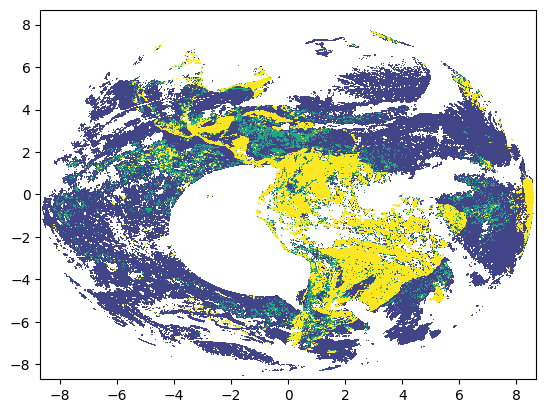

In [ ]:
#ds.AOD.plot(vmin=0, vmax=2)
import numpy as np
import matplotlib.pyplot as plt

lon = np.rad2deg(ds.x)
lat = (ds.y * 180)/np.pi

plt.contourf(lon, lat, ds.AOD, vmin=0, vmax=2)
plt.show()

In [ ]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

# Abrir o dataset
arquivo = '/content/samples/OR_ABI-L2-AODF-M6_G16_s20240671800203_e20240671809511_c20240671814262.nc'
ds = xr.open_dataset(arquivo)

# Extraindo a variável AOD
aod = ds['AOD']

# Pegando a projeção GOES
proj_info = ds['goes_imager_projection']
sat_height = proj_info.perspective_point_height
sat_lon = proj_info.longitude_of_projection_origin
sat_sweep = proj_info.sweep_angle_axis

# Coordenadas projetadas (x e y estão em radianos de ângulo visto pelo satélite)
x = ds['x'] * sat_height
y = ds['y'] * sat_height

# Criando a projeção do GOES-16
geos_proj = ccrs.Geostationary(central_longitude=sat_lon,
                               satellite_height=sat_height,
                               sweep_axis=sat_sweep)

#pd.read_csv('/content/drive/MyDrive/Meteorologia USP/TCC/Aeronet Dados/Sao_Paulo.csv')

In [ ]:
ds["AOD"]

<xarray.DataArray 'AOD' (y: 5424, x: 5424)> Size: 118MB
[29419776 values with dtype=float32]
Coordinates:
    t                                datetime64[ns] 8B ...
  * y                                (y) float32 22kB 0.1518 0.1518 ... -0.1518
  * x                                (x) float32 22kB -0.1518 -0.1518 ... 0.1518
    y_image                          float32 4B ...
    x_image                          float32 4B ...
    sunglint_angle                   float32 4B ...
    retrieval_local_zenith_angle     float32 4B ...
    quantitative_local_zenith_angle  float32 4B ...
    retrieval_solar_zenith_angle     float32 4B ...
    quantitative_solar_zenith_angle  float32 4B ...
    aod_product_wavelength           float32 4B ...
Attributes:
    long_name:            ABI L2+ Aerosol Optical Depth at 550 nm
    standard_name:        atmosphere_extinction_optical_thickness_due_to_ambi...
    valid_range:          [    0 65530]
    units:                1
    resolution:           y: 0.000056 rad x: 0.000056 rad
    grid_mapping:         goes_imager_projection
    cell_methods:         sunglint_angle: point (no pixel produced over sea o...
    ancillary_variables:  DQF

In [ ]:
# Calculate latitude and longitude from GOES ABI fixed grid projection data
# GOES ABI fixed grid projection is a map projection relative to the GOES satellite
# Units: latitude in °N (°S < 0), longitude in °E (°W < 0)
# See GOES-R Product User Guide (PUG) Volume 5 (L2 products) Section 4.2.8 for details & example of calculations
# "file_id" is an ABI L1b or L2 .nc file opened using the netCDF4 library

def calculate_degrees(file_id):

    # Read in GOES ABI fixed grid projection variables and constants
    x_coordinate_1d = file_id.variables['x'][:]  # E/W scanning angle in radians
    y_coordinate_1d = file_id.variables['y'][:]  # N/S elevation angle in radians
    projection_info = file_id.variables['goes_imager_projection']
    lon_origin = projection_info.longitude_of_projection_origin
    H = projection_info.perspective_point_height+projection_info.semi_major_axis
    r_eq = projection_info.semi_major_axis
    r_pol = projection_info.semi_minor_axis

    # Create 2D coordinate matrices from 1D coordinate vectors
    x_coordinate_2d, y_coordinate_2d = np.meshgrid(x_coordinate_1d, y_coordinate_1d)

    # Equations to calculate latitude and longitude
    lambda_0 = (lon_origin*np.pi)/180.0
    a_var = np.power(np.sin(x_coordinate_2d),2.0) + (np.power(np.cos(x_coordinate_2d),2.0)*(np.power(np.cos(y_coordinate_2d),2.0)+(((r_eq*r_eq)/(r_pol*r_pol))*np.power(np.sin(y_coordinate_2d),2.0))))
    b_var = -2.0*H*np.cos(x_coordinate_2d)*np.cos(y_coordinate_2d)
    c_var = (H**2.0)-(r_eq**2.0)
    r_s = (-1.0*b_var - np.sqrt((b_var**2)-(4.0*a_var*c_var)))/(2.0*a_var)
    s_x = r_s*np.cos(x_coordinate_2d)*np.cos(y_coordinate_2d)
    s_y = - r_s*np.sin(x_coordinate_2d)
    s_z = r_s*np.cos(x_coordinate_2d)*np.sin(y_coordinate_2d)

    # Ignore numpy errors for sqrt of negative number; occurs for GOES-16 ABI CONUS sector data
    np.seterr(all='ignore')

    abi_lat = (180.0/np.pi)*(np.arctan(((r_eq*r_eq)/(r_pol*r_pol))*((s_z/np.sqrt(((H-s_x)*(H-s_x))+(s_y*s_y))))))
    abi_lon = (lambda_0 - np.arctan(s_y/(H-s_x)))*(180.0/np.pi)

    ds = xr.open_dataset(xr.backends.NetCDF4DataStore(file_id))

    # Adicionar coordenadas lat/lon
    ds = ds.assign_coords({
        "lat": (["y", "x"], abi_lat),
        "lon": (["y", "x"], abi_lon)
    })

    # Ajustar atributos
    ds['lat'].attrs = {"units": "degrees_north", "standard_name": "latitude"}
    ds['lon'].attrs = {"units": "degrees_east", "standard_name": "longitude"}
    return abi_lat, abi_lon, ds

In [ ]:
# Import Python packages

# Library to work with netCDF files
from netCDF4 import Dataset

# Library to perform array operations
import numpy as np

# Module to set filesystem paths appropriate for user's operating system
from pathlib import Path

In [ ]:
# Open an ABI netCDF4 data file

# Enter directory and file name for ABI data file
directory_path = Path.cwd()  # Current working directory
#file_name = 'OR_ABI-L2-FDCM1-M6_G17_s20212291400255_e20212291400312_c20212291400457.nc'
file_name = '/content/samples/OR_ABI-L2-AODF-M6_G16_s20240671800203_e20240671809511_c20240671814262.nc'
file_path = directory_path / file_name

# Open the file using the netCDF4 library
file_id = Dataset(file_path)

In [ ]:
# Print arrays of calculated latitude and longitude

# Call function to calculate latitude and longitude from GOES ABI fixed grid projection data
abi_lat, abi_lon, ds = calculate_degrees(file_id)

# Print latitude array
print(abi_lat)

# Print max and min of latitude data to check data range
print('The maximum latitude value is', np.max(abi_lat), 'degrees')
print('The minimum latitude value is', np.min(abi_lat), 'degrees')

# Print longitude array
print(abi_lon)

# Print max and min of longitude data to check data range
print('The maximum longitude value is', np.max(abi_lon), 'degrees')
print('The minimum longitude value is', np.min(abi_lon), 'degrees')

[[-- -- -- ... -- -- --]
 [-- -- -- ... -- -- --]
 [-- -- -- ... -- -- --]
 ...
 [-- -- -- ... -- -- --]
 [-- -- -- ... -- -- --]
 [-- -- -- ... -- -- --]]
The maximum latitude value is 81.15031109865967 degrees
The minimum latitude value is -81.1520213469666 degrees
[[-- -- -- ... -- -- --]
 [-- -- -- ... -- -- --]
 [-- -- -- ... -- -- --]
 ...
 [-- -- -- ... -- -- --]
 [-- -- -- ... -- -- --]
 [-- -- -- ... -- -- --]]
The maximum longitude value is 6.217063076116357 degrees
The minimum longitude value is -156.25192665226692 degrees


In [ ]:
#Cria um novo arquivo com arqs de lat e lon e aod
import xarray as xr

ds_1 = xr.Dataset(
    data_vars={
        "AOD": (("y", "x"), ds.AOD.values)
    },
    coords={
        "lat": (("y", "x"), abi_lat),
        "lon": (("y", "x"), abi_lon)
    },
    attrs={
        "description": "AOD com coordenadas 2D do GOES"
    }
)


In [ ]:
#Pesquisa o ponto mais proxima da lat e lon fornecida
import numpy as np

def find_nearest_latlon(lat_array, lon_array, target_lat, target_lon):
    """
    Encontra o índice (linha, coluna) no array 2D com o ponto mais próximo
    da latitude e longitude fornecidas.

    lat_array, lon_array: arrays 2D das latitudes e longitudes do GOES (ex: abi_lat.data)
    target_lat, target_lon: latitude e longitude alvo em graus (float)

    Retorna:
        (linha, coluna) do ponto mais próximo
    """
    # Calcula a distância quadrada simples entre todos os pontos e o alvo
    dist_squared = (lat_array - target_lat)**2 + (lon_array - target_lon)**2

    # Encontra o índice linear do mínimo da distância
    idx_flat = np.argmin(dist_squared)

    # Converte índice linear para índice 2D
    idx_2d = np.unravel_index(idx_flat, lat_array.shape)

    return (int(idx_2d[0]), int(idx_2d[1]))

In [ ]:
#Pesquisa o valor do aod para respectiva lat e lon em graus
indice=find_nearest_latlon(abi_lat.data, abi_lon.data,-23.5615,-46.734983	)
ds_1.AOD[indice]
print(f"Latitude do ponto: {abi_lat.data[indice]}")
print(f"Longitude do ponto: {abi_lon.data[indice]}")
print(f"AOD do ponto: {ds_1.AOD[indice]}")

Latitude do ponto: -23.559218243315346
Longitude do ponto: -46.744571236289595
AOD do ponto: <xarray.DataArray 'AOD' ()> Size: 4B
array(3.9686792, dtype=float32)
Coordinates:
    lat      float64 8B -23.56
    lon      float64 8B -46.74


In [ ]:
[indice]


[(3932, 4042)]

In [ ]:
# Índice central (mais próximo do ponto dado)
i, j = 3932, 4042

# Índices vizinhos: esquerda, direita, cima, baixo
vizinhos = [
    (i, j),         # ponto central
    (i, j - 1),     # esquerda
    (i, j + 1),     # direita
    (i - 1, j),     # cima
    (i + 1, j)      # baixo
]

# Loop para imprimir os valores
for idx in vizinhos:
    lat_val = abi_lat.data[idx]
    lon_val = abi_lon.data[idx]
    aod_val = ds_1.AOD[idx].values
    print(f"Índice: {idx} | Lat: {lat_val:.4f} | Lon: {lon_val:.4f} | AOD: {aod_val:.4f}")


Índice: (3932, 4042) | Lat: -23.5592 | Lon: -46.7446 | AOD: 3.9687
Índice: (3932, 4041) | Lat: -23.5584 | Lon: -46.7690 | AOD: 1.2676
Índice: (3932, 4043) | Lat: -23.5601 | Lon: -46.7201 | AOD: 1.1648
Índice: (3931, 4042) | Lat: -23.5380 | Lon: -46.7506 | AOD: 0.9528
Índice: (3933, 4042) | Lat: -23.5805 | Lon: -46.7385 | AOD: 2.2508


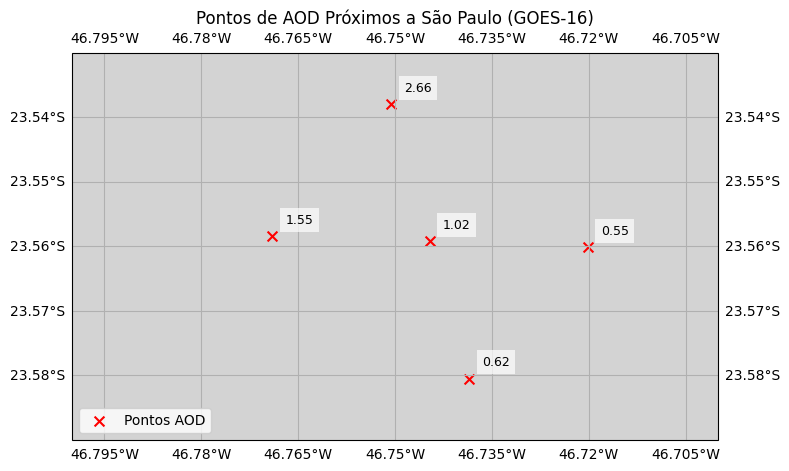

In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

# Coordenadas dos pontos
lat_pontos = [-23.5592, -23.5584, -23.5601, -23.5380, -23.5805]
lon_pontos = [-46.7446, -46.7690, -46.7201, -46.7506, -46.7385]
aod_vals = [1.0170, 1.2676, 0.5479, 2.6644, 0.6238]

# Criação do mapa genérico
fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-46.80, -46.70, -23.59, -23.53], crs=ccrs.PlateCarree())

# Adiciona feições geográficas
ax.coastlines(resolution='10m')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
ax.add_feature(cfeature.LAKES, facecolor='lightblue')
ax.add_feature(cfeature.RIVERS)

# Adiciona os pontos com marcador
ax.scatter(lon_pontos, lat_pontos, color='red', s=50, marker='x', label='Pontos AOD')

# Adiciona os valores AOD como texto
for lat, lon, aod in zip(lat_pontos, lon_pontos, aod_vals):
    texto = f"{aod:.2f}" if not np.isnan(aod) else "NaN"
    ax.text(lon + 0.002, lat + 0.002, texto, fontsize=9, transform=ccrs.PlateCarree(),
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

# Legenda e grade
ax.legend(loc='lower left')
ax.gridlines(draw_labels=True)

plt.title("Pontos de AOD Próximos a São Paulo (GOES-16)")
plt.tight_layout()
plt.show()


# Mapas e Comparações

/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_ocean.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


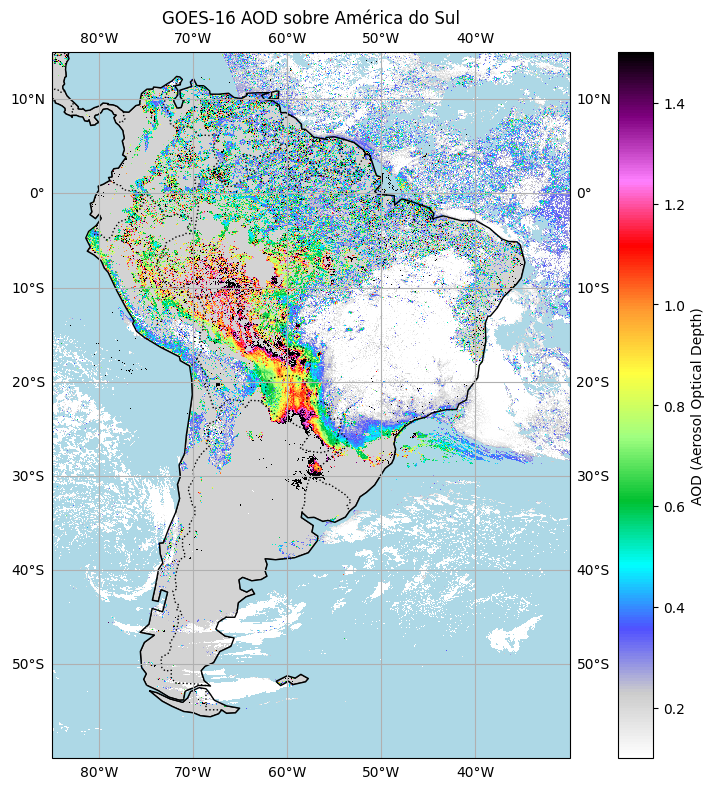

In [ ]:
#@title Produto Goes16 Teste Mapa Inicial
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

# Abrir o dataset
arquivo = '/content/drive/MyDrive/Meteorologia USP/TCC/DadosGOES16_AOD/OR_ABI-L2-AODF-M6_G16_s20242331800202_e20242331809510_c20242331814287.nc'
ds = xr.open_dataset(arquivo)

# Extraindo a variável AOD
aod = ds['AOD']

# Pegando a projeção GOES
proj_info = ds['goes_imager_projection']
sat_height = proj_info.perspective_point_height
sat_lon = proj_info.longitude_of_projection_origin
sat_sweep = proj_info.sweep_angle_axis

# Coordenadas projetadas (x e y estão em radianos de ângulo visto pelo satélite)
x = ds['x'] * sat_height
y = ds['y'] * sat_height

# Criando a projeção do GOES-16
geos_proj = ccrs.Geostationary(central_longitude=sat_lon,
                               satellite_height=sat_height,
                               sweep_axis=sat_sweep)

# Projeção de destino (lat/lon simples)
target_proj = ccrs.PlateCarree()

# Plot
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=target_proj)
ax.set_extent([-85, -30, -60, 15], crs=target_proj)  # América do Sul

# Adiciona recursos de mapa
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')

# Grid de long/lat
ax.gridlines(draw_labels=True)

colors = ['#CCCCCC', '#5050FF', '#00FFFF', '#00C030', '#A0FF80',
          '#FFFF40', '#FF9830', '#FF0000', '#FF80FF', '#800080', '#000000']
cmap = LinearSegmentedColormap.from_list('my_cmap', ['#FFFFFF'] + colors, N=256)

# Plot com transformação da projeção do satélite para latitude/longitude
img = ax.pcolormesh(x, y, aod, transform=geos_proj,cmap=cmap, vmin=0.1, vmax=1.5)

# Barra de cor
cbar = plt.colorbar(img, ax=ax, orientation='vertical', label='AOD (Aerosol Optical Depth)')

plt.title("GOES-16 AOD sobre América do Sul")
plt.tight_layout()
plt.show()



In [ ]:
#@title Mapas AODF 20/08 - 10/09/24 com Estrelas
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import os
import glob
import re
from datetime import datetime
from matplotlib.colors import LinearSegmentedColormap

colors = ['#CCCCCC', '#5050FF', '#00FFFF', '#00C030', '#A0FF80',
          '#FFFF40', '#FF9830', '#FF0000', '#FF80FF', '#800080', '#000000']
cmap = LinearSegmentedColormap.from_list('my_cmap', ['#FFFFFF'] + colors, N=256)

# Pasta dos arquivos e das imagens de saída
pasta = '/content/drive/MyDrive/Meteorologia USP/TCC/DadosGOES16_AOD/'
saida_pasta = '/content/drive/MyDrive/Meteorologia USP/TCC/AodGoes16_imagens/'

# Lista todos os arquivos .nc da pasta
arquivos_nc = glob.glob(os.path.join(pasta, '*.nc'))

# Coordenadas das estações e cores das estrelas
estacoes = {
    'São_Paulo': {'coords': (-23.5505, -46.6333), 'cor': 'white'},
    'Cuiaba-Miranda': {'coords': (-15.73091, -56.07086), 'cor': 'darkred'},
    'Alta-Floresta': {'coords': (-9.908354, -56.064393), 'cor': 'darkgreen'}
}

# Loop sobre os arquivos
for arquivo in arquivos_nc:
    # Extrai nome base e tenta pegar a data do arquivo
    nome_base = os.path.basename(arquivo)
    match = re.search(r'_s(\d{7})', nome_base)

    if match:
        data_str = match.group(1)
        nome_arquivo = f"AOD_{data_str}.png"
        caminho_saida = os.path.join(saida_pasta, nome_arquivo)

        # Verifica se a imagem já existe
        if os.path.exists(caminho_saida):
            print(f"Já existe: {caminho_saida}")
            continue  # pula para o próximo arquivo

        # Caso não exista, processa
        ds = xr.open_dataset(arquivo)
        aod = ds['AOD']

        proj_info = ds['goes_imager_projection']
        sat_height = proj_info.perspective_point_height
        sat_lon = proj_info.longitude_of_projection_origin
        sat_sweep = proj_info.sweep_angle_axis

        x = ds['x'] * sat_height
        y = ds['y'] * sat_height

        geos_proj = ccrs.Geostationary(central_longitude=sat_lon,
                                       satellite_height=sat_height,
                                       sweep_axis=sat_sweep)
        target_proj = ccrs.PlateCarree()

        fig = plt.figure(figsize=(10, 8))
        ax = plt.axes(projection=target_proj)
        ax.set_extent([-85, -30, -60, 15], crs=target_proj)

        ax.coastlines()
        ax.add_feature(cfeature.BORDERS, linestyle=':')
        ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgray')
        ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
        ax.gridlines(draw_labels=True)

        vmin = max(0.1, float(np.nanmin(aod)))
        vmax = float(np.nanmax(aod))

        img = ax.pcolormesh(x, y, aod, transform=geos_proj,
                            cmap=cmap, vmin=vmin, vmax=vmax)

        cbar = plt.colorbar(img, ax=ax, orientation='vertical', label='AOD (Aerosol Optical Depth) 550nm')

        for nome, info in estacoes.items():
            lat, lon = info['coords']
            cor = info['cor']
            ax.plot(lon, lat, marker='*', color=cor, markersize=15,
                    markeredgecolor='black', markeredgewidth=1.5,
                    transform=target_proj)
            ax.text(lon + 1, lat + 1, nome.replace('-', ' '), color='black',
                    fontsize=10, transform=target_proj)

        # Converte a data para string
        ano = int(data_str[:4])
        dia_juliano = int(data_str[4:])
        data = datetime.strptime(f'{ano} {dia_juliano}', '%Y %j')
        data_formatada = data.strftime('%d/%m/%Y')

        plt.title(f"GOES-16 AOD sobre América do Sul - {data_formatada}")
        plt.tight_layout()
        plt.savefig(caminho_saida, dpi=300, transparent=True, pad_inches=0)
        plt.close()
        ds.close()
        print(f"Imagem salva: {caminho_saida}")
    else:
        print(f"Data não encontrada no nome do arquivo: {nome_base}")


Já existe: /content/drive/MyDrive/Meteorologia USP/TCC/AodGoes16_imagens/AOD_2024233.png
Já existe: /content/drive/MyDrive/Meteorologia USP/TCC/AodGoes16_imagens/AOD_2024234.png
Já existe: /content/drive/MyDrive/Meteorologia USP/TCC/AodGoes16_imagens/AOD_2024235.png
Já existe: /content/drive/MyDrive/Meteorologia USP/TCC/AodGoes16_imagens/AOD_2024236.png
Já existe: /content/drive/MyDrive/Meteorologia USP/TCC/AodGoes16_imagens/AOD_2024237.png
Já existe: /content/drive/MyDrive/Meteorologia USP/TCC/AodGoes16_imagens/AOD_2024238.png
Já existe: /content/drive/MyDrive/Meteorologia USP/TCC/AodGoes16_imagens/AOD_2024239.png
Já existe: /content/drive/MyDrive/Meteorologia USP/TCC/AodGoes16_imagens/AOD_2024240.png
Já existe: /content/drive/MyDrive/Meteorologia USP/TCC/AodGoes16_imagens/AOD_2024241.png
Já existe: /content/drive/MyDrive/Meteorologia USP/TCC/AodGoes16_imagens/AOD_2024242.png
Já existe: /content/drive/MyDrive/Meteorologia USP/TCC/AodGoes16_imagens/AOD_2024243.png
Já existe: /content/d

[✓] DataFrame salvo: /content/drive/MyDrive/Meteorologia USP/TCC/correlacoes_dados/AOD_Comparacao_18h_Sao_Paulo.csv (16 pontos)
[✓] DataFrame salvo: /content/drive/MyDrive/Meteorologia USP/TCC/correlacoes_dados/AOD_Comparacao_18h_CUIABA.csv (14 pontos)
[✓] DataFrame salvo: /content/drive/MyDrive/Meteorologia USP/TCC/correlacoes_dados/AOD_Comparacao_18h_AltaFloresta.csv (2 pontos)


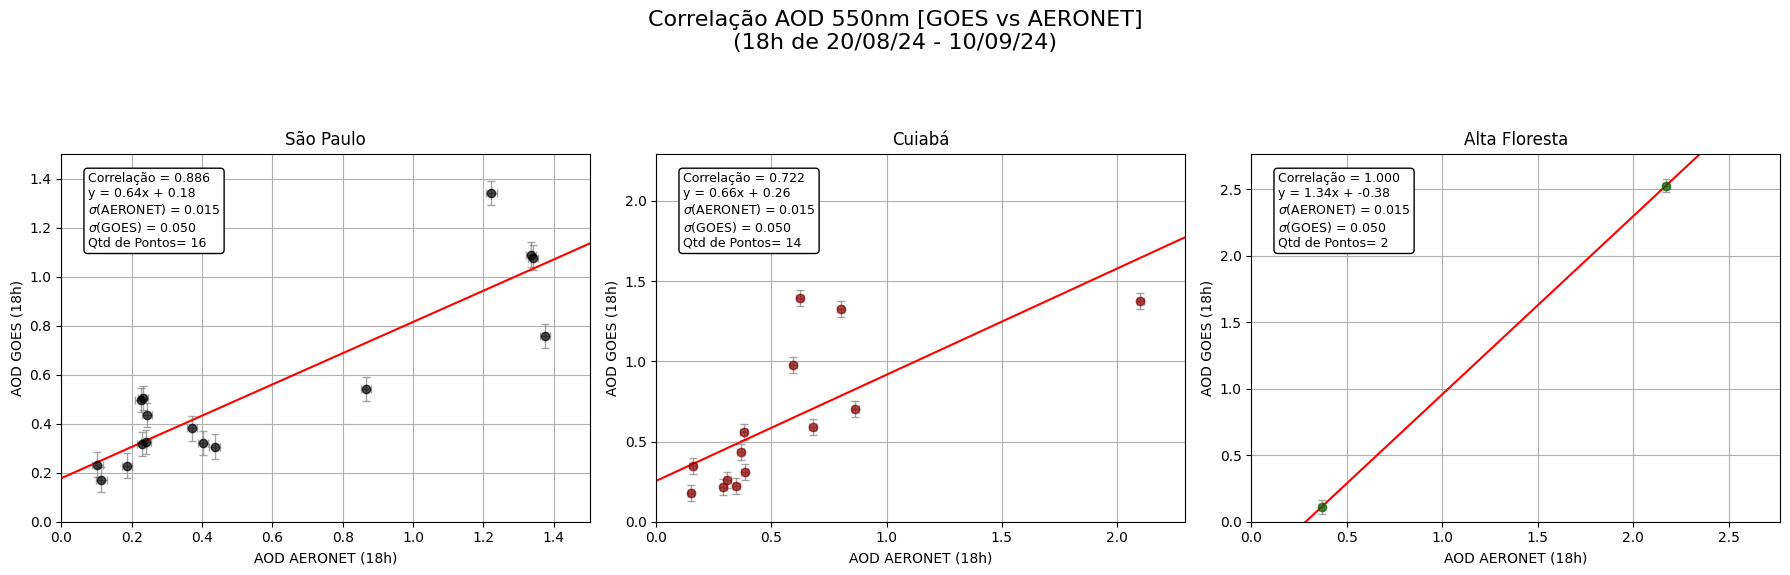

[✓] Figura salva: /content/drive/MyDrive/Meteorologia USP/TCC/correlacoes_imagens/correlacoes_18h_lado_a_lado.png


In [ ]:
#@title Correlações 18h 20/08/24 - 10/09/24
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# === Função para processar e gerar dados de cada cidade ===
def processar_cidade(cidade, output_dir):
    arquivo_goes = f'/content/drive/MyDrive/Meteorologia USP/TCC/GOES16 Produto AOD/AOD_GOES16_18h_{cidade}.csv'
    arquivo_aeronet = f'/content/drive/MyDrive/Meteorologia USP/TCC/Aeronet Dados/{cidade}.csv'

    df_goes = pd.read_csv(arquivo_goes)
    df_goes['data_aeronet'] = pd.to_datetime(df_goes['data_aeronet'])
    df_goes['date'] = df_goes['data_aeronet'].dt.date

    df_aeronet = pd.read_csv(arquivo_aeronet)
    df_aeronet['Date(dd:mm:yyyy)'] = pd.to_datetime(df_aeronet['Date(dd:mm:yyyy)'], format='%d:%m:%Y')
    df_aeronet['date'] = df_aeronet['Date(dd:mm:yyyy)'].dt.date

    col_aod_aeronet = 'AOD_550nm'
    col_aod_goes = 'aod'

    df_aeronet[col_aod_aeronet] = df_aeronet[col_aod_aeronet].astype(str).str.replace(',', '.').astype(float)
    df_goes[col_aod_goes] = df_goes[col_aod_goes].astype(str).str.replace(',', '.').astype(float)

    df_aeronet = df_aeronet.replace(-999, np.nan)
    df_goes = df_goes.replace(-999, np.nan)

    df_aeronet = df_aeronet[df_aeronet[col_aod_aeronet] >= 0.1]
    df_goes = df_goes[df_goes[col_aod_goes] >= 0.1]

    df_merged = pd.merge(df_aeronet, df_goes, on='date', how='inner').drop_duplicates(subset=['date'])

    correlacao = df_merged[[col_aod_aeronet, col_aod_goes]].corr().iloc[0, 1]

    output_csv = os.path.join(output_dir, f'AOD_Comparacao_18h_{cidade}.csv')
    df_merged.to_csv(output_csv, index=False)
    print(f'[✓] DataFrame salvo: {output_csv} ({len(df_merged)} pontos)')

    return df_merged, correlacao

# === Diretório de saída ===
output_dir = '/content/drive/MyDrive/Meteorologia USP/TCC/correlacoes_dados/'
os.makedirs(output_dir, exist_ok=True)

# === Lista de cidades ===
cidades = ['Sao_Paulo', 'CUIABA', 'AltaFloresta']
titulos = ['São Paulo', 'Cuiabá', 'Alta Floresta']
cores = ['black', 'darkred', 'darkgreen']

# === Criar painel com 1 linha e 3 colunas ===
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # <- Ajuste aqui

for ax, cidade, titulo, cor in zip(axes, cidades, titulos, cores):
    df_merged, correlacao = processar_cidade(cidade, output_dir)

    col_aod_aeronet = 'AOD_550nm'
    col_aod_goes = 'aod'

    x = df_merged[col_aod_aeronet]
    y = df_merged[col_aod_goes]
    valid = ~(x.isna() | y.isna())
    x_valid = x[valid]
    y_valid = y[valid]

    if len(x_valid) > 0:
        min_val = min(x_valid.min(), y_valid.min())
        max_val = max(x_valid.max(), y_valid.max())
        margem = (max_val - min_val) * 0.1
        limite_inf = max(0, min_val - margem)
        limite_sup = max_val + margem
    else:
        limite_inf, limite_sup = 0, 2

    ax.errorbar(x_valid, y_valid,
            xerr=0.015, yerr=0.05,
            fmt='o', color=cor, alpha=0.7, ecolor='gray',
            elinewidth=1, capsize=3, label=titulo)

    if len(x_valid) > 1:
        coeffs = np.polyfit(x_valid, y_valid, 1)
        m, b = coeffs
        x_fit = np.array([limite_inf, limite_sup])
        y_fit = m * x_fit + b
        ax.plot(x_fit, y_fit, 'r-', label=f'y = {m:.2f}x + {b:.2f}')
#        ax.legend()

    ax.set_xlim(limite_inf, limite_sup)
    ax.set_ylim(limite_inf, limite_sup)

    ax.set_xlabel('AOD AERONET (18h)')
    ax.set_ylabel('AOD GOES (18h)')
    ax.set_title(f'{titulo}')
    ax.grid(True)
    # Adicionar texto com as incertezas fixas
    sigma_aeronet = r'$\sigma$(AERONET) = 0.015'
    sigma_goes = r'$\sigma$(GOES) = 0.050'
    equation = f'y = {m:.2f}x + {b:.2f}'
    corr_text = f'Correlação = {correlacao:.3f}'
    N = f'Qtd de Pontos= {len(df_merged)}'
    # Texto explicativo no canto superior esquerdo do gráfico
    ax.text(0.05, 0.95,
            f'{corr_text}\n{equation}\n{sigma_aeronet}\n{sigma_goes}\n{N}',
            transform=ax.transAxes,
            fontsize=9,
            verticalalignment='top',
            bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))


plt.suptitle('Correlação AOD 550nm [GOES vs AERONET]\n(18h de 20/08/24 - 10/09/24)', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.90])

# Salvar figura
saida = '/content/drive/MyDrive/Meteorologia USP/TCC/correlacoes_imagens/correlacoes_18h_lado_a_lado.png'
plt.savefig(saida, dpi=300, bbox_inches='tight', transparent=True, pad_inches=0)
plt.show()
plt.close()
print(f'[✓] Figura salva: {saida}')


[✓] DataFrame salvo: /content/drive/MyDrive/Meteorologia USP/TCC/correlacoes_dados/AOD_Comparacao_Sao_Paulo.csv (81 pontos)
Correlação para Sao_Paulo: 0.913
[✓] DataFrame salvo: /content/drive/MyDrive/Meteorologia USP/TCC/correlacoes_dados/AOD_Comparacao_CUIABA.csv (41 pontos)
Correlação para CUIABA: 0.824
[✓] DataFrame salvo: /content/drive/MyDrive/Meteorologia USP/TCC/correlacoes_dados/AOD_Comparacao_AltaFloresta.csv (9 pontos)
Correlação para AltaFloresta: 0.981


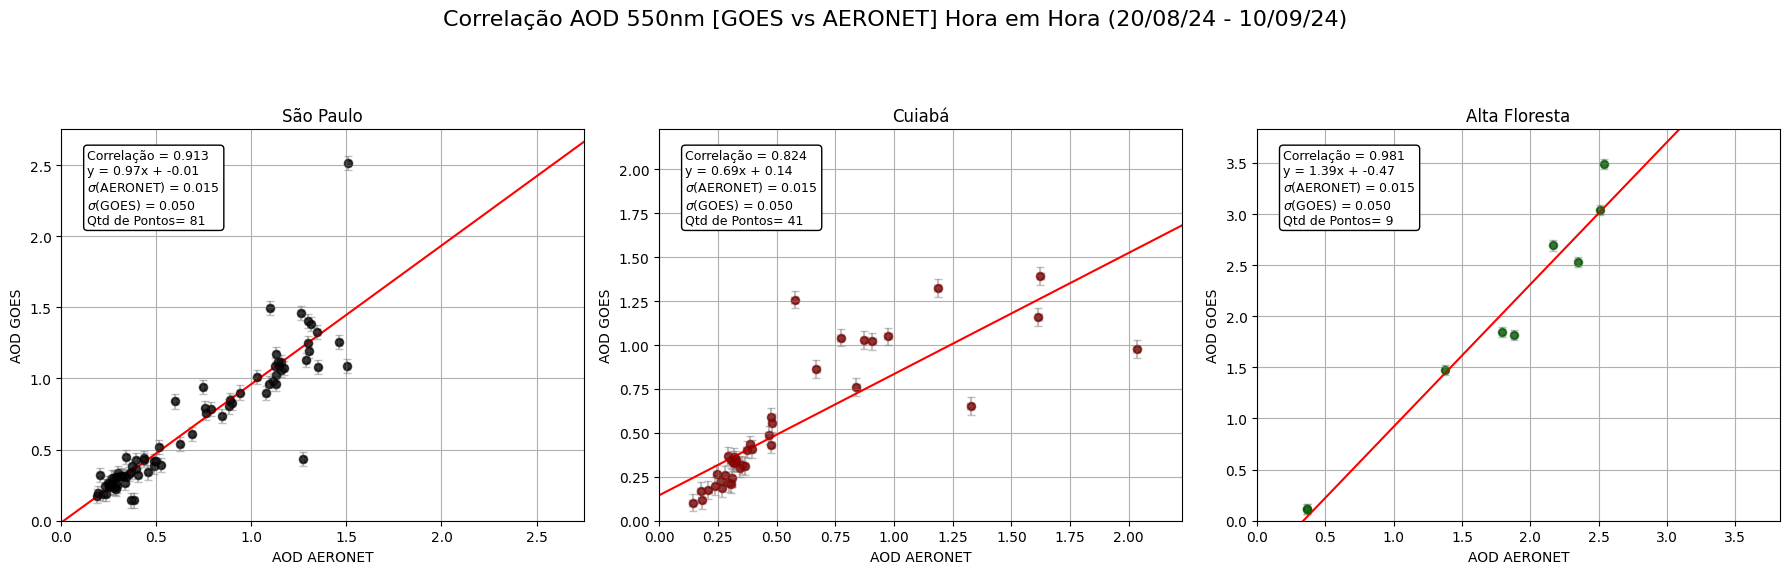

[✓] Figura salva: /content/drive/MyDrive/Meteorologia USP/TCC/correlacoes_imagens/correlacoes_diarias_lado_a_lado.png


In [ ]:
#@title Correlação Diaria 20/08/24 - 10/09/24
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# === Função para processar e gerar dados de cada cidade ===
def processar_cidade(cidade, output_dir):
    arquivo_goes = f'/content/drive/MyDrive/Meteorologia USP/TCC/GOES16 Produto AOD/AOD_GOES16_{cidade}.csv'
    arquivo_aeronet = f'/content/drive/MyDrive/Meteorologia USP/TCC/Aeronet Dados/{cidade}.csv'

    df_goes = pd.read_csv(arquivo_goes)
    df_goes['datetime_aeronet'] = pd.to_datetime(df_goes['data_aeronet'] + ' ' + df_goes['hora_aeronet'])
    df_goes['aod'] = df_goes['aod'].astype(str).str.replace(',', '.').astype(float)
    df_goes = df_goes.replace(-999, np.nan)
    df_goes = df_goes[df_goes['aod'] >= 0.1]

    df_aeronet = pd.read_csv(arquivo_aeronet)
    df_aeronet['datetime'] = pd.to_datetime(df_aeronet['Date(dd:mm:yyyy)'] + ' ' + df_aeronet['Time(hh:mm:ss)'], format='%d:%m:%Y %H:%M:%S')
    df_aeronet['AOD_550nm'] = df_aeronet['AOD_550nm'].astype(str).str.replace(',', '.').astype(float)
    df_aeronet = df_aeronet.replace(-999, np.nan)
    df_aeronet = df_aeronet[df_aeronet['AOD_550nm'] >= 0.1]

    matches = []
    for idx, row in df_goes.iterrows():
        dt_aeronet = row['datetime_aeronet']
        aod_goes = row['aod']
        df_match = df_aeronet[df_aeronet['datetime'] == dt_aeronet]
        if not df_match.empty:
            for _, aer_row in df_match.iterrows():
                matches.append({
                    'datetime': dt_aeronet,
                    'date': dt_aeronet.date(),
                    'AOD_GOES': aod_goes,
                    'AOD_AERONET': aer_row['AOD_550nm']
                })

    df_comp = pd.DataFrame(matches).drop_duplicates(subset=['datetime', 'AOD_GOES', 'AOD_AERONET'])
    output_csv = os.path.join(output_dir, f'AOD_Comparacao_{cidade}.csv')
    df_comp.to_csv(output_csv, index=False)
    print(f'[✓] DataFrame salvo: {output_csv} ({len(df_comp)} pontos)')

    if len(df_comp) >= 2:
        correlacao = df_comp[['AOD_AERONET', 'AOD_GOES']].corr().iloc[0, 1]
        print(f"Correlação para {cidade}: {correlacao:.3f}")
    else:
        correlacao = np.nan
        print(f"Poucos pares para calcular correlação em {cidade}.")

    return df_comp, correlacao

# Diretório de saída
output_dir = '/content/drive/MyDrive/Meteorologia USP/TCC/correlacoes_dados/'
os.makedirs(output_dir, exist_ok=True)

# Lista atualizada (sem La Paz)
cidades = ['Sao_Paulo', 'CUIABA', 'AltaFloresta']
titulos = ['São Paulo', 'Cuiabá', 'Alta Floresta']
cores = ['black', 'darkred', 'darkgreen']

# Painel com 1 linha e 3 colunas
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for ax, cidade, titulo, cor in zip(axes, cidades, titulos, cores):
    df_comp, correlacao = processar_cidade(cidade, output_dir)

    x = df_comp['AOD_AERONET']
    y = df_comp['AOD_GOES']
    valid = ~(x.isna() | y.isna())
    x_valid = x[valid]
    y_valid = y[valid]

    if len(x_valid) > 0:
        min_val = min(x_valid.min(), y_valid.min())
        max_val = max(x_valid.max(), y_valid.max())
        margem = (max_val - min_val) * 0.1
        limite_inf = max(0, min_val - margem)
        limite_sup = max_val + margem
    else:
        limite_inf, limite_sup = 0, 2

    ax.errorbar(x_valid, y_valid,
            xerr=0.015, yerr=0.05,
            fmt='o', color=cor, alpha=0.5, ecolor='gray',
            elinewidth=1.5, capsize=3, label=titulo)

    ax.scatter(x_valid, y_valid, color=cor, s=25, alpha=0.7, edgecolors='k', label=titulo)

    if len(x_valid) > 1:
        m, b = np.polyfit(x_valid, y_valid, 1)
        x_fit = np.array([limite_inf, limite_sup])
        y_fit = m * x_fit + b
        ax.plot(x_fit, y_fit, 'r-', label=f'y = {m:.2f}x + {b:.2f}')
        #ax.legend()

    ax.set_xlim(limite_inf, limite_sup)
    ax.set_ylim(limite_inf, limite_sup)

    ax.set_xlabel('AOD AERONET')
    ax.set_ylabel('AOD GOES')
    ax.set_title(f'{titulo}')
    ax.grid(True)

    # Adicionar texto com as incertezas fixas
    sigma_aeronet = r'$\sigma$(AERONET) = 0.015'
    sigma_goes = r'$\sigma$(GOES) = 0.050'
    equation = f'y = {m:.2f}x + {b:.2f}'
    corr_text = f'Correlação = {correlacao:.3f}'
    N = f'Qtd de Pontos= {len(df_comp)}'
    # Texto explicativo no canto superior esquerdo do gráfico
    ax.text(0.05, 0.95,
            f'{corr_text}\n{equation}\n{sigma_aeronet}\n{sigma_goes}\n{N}',
            transform=ax.transAxes,
            fontsize=9,
            verticalalignment='top',
            bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))


plt.suptitle('Correlação AOD 550nm [GOES vs AERONET] Hora em Hora (20/08/24 - 10/09/24)', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.90])

# Salvar a imagem
saida = '/content/drive/MyDrive/Meteorologia USP/TCC/correlacoes_imagens/correlacoes_diarias_lado_a_lado.png'
plt.savefig(saida, dpi=300, bbox_inches='tight', transparent=True, pad_inches=0)
plt.show()
plt.close()
print(f'[✓] Figura salva: {saida}')


[✓] DataFrame salvo: /content/drive/MyDrive/Meteorologia USP/TCC/correlacoes_dados/AOD_Comparacao_Sao_Paulo.csv (81 pontos)
Correlação para Sao_Paulo: 0.913
[✓] DataFrame salvo: /content/drive/MyDrive/Meteorologia USP/TCC/correlacoes_dados/AOD_Comparacao_CUIABA.csv (41 pontos)
Correlação para CUIABA: 0.824
[✓] DataFrame salvo: /content/drive/MyDrive/Meteorologia USP/TCC/correlacoes_dados/AOD_Comparacao_AltaFloresta.csv (9 pontos)
Correlação para AltaFloresta: 0.981


/tmp/ipython-input-20-1478606470.py:71: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = plt.cm.get_cmap('tab20', len(all_dates))
/tmp/ipython-input-20-1478606470.py:149: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])


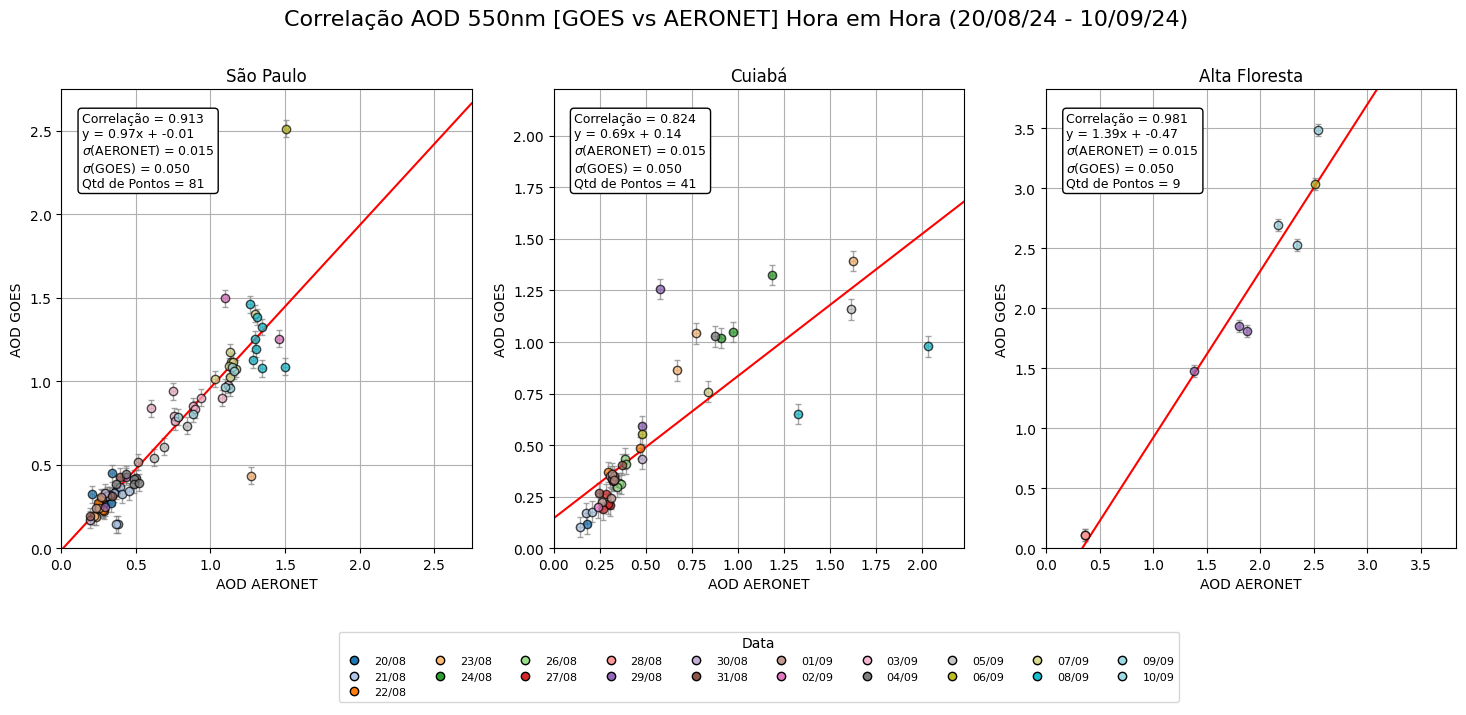

[✓] Figura salva: /content/drive/MyDrive/Meteorologia USP/TCC/correlacoes_imagens/correlacoes_dias_legenda_unica.png


In [ ]:
#@title Correlação Diaria 20/08/24 - 10/09/24 - Coloridos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import matplotlib.dates as mdates

# === Função para processar e gerar dados de cada cidade ===
def processar_cidade(cidade, output_dir):
    arquivo_goes = f'/content/drive/MyDrive/Meteorologia USP/TCC/GOES16 Produto AOD/AOD_GOES16_{cidade}.csv'
    arquivo_aeronet = f'/content/drive/MyDrive/Meteorologia USP/TCC/Aeronet Dados/{cidade}.csv'

    df_goes = pd.read_csv(arquivo_goes)
    df_goes['datetime_aeronet'] = pd.to_datetime(df_goes['data_aeronet'] + ' ' + df_goes['hora_aeronet'])
    df_goes['aod'] = df_goes['aod'].astype(str).str.replace(',', '.').astype(float)
    df_goes = df_goes.replace(-999, np.nan)
    df_goes = df_goes[df_goes['aod'] >= 0.1]

    df_aeronet = pd.read_csv(arquivo_aeronet)
    df_aeronet['datetime'] = pd.to_datetime(df_aeronet['Date(dd:mm:yyyy)'] + ' ' + df_aeronet['Time(hh:mm:ss)'], format='%d:%m:%Y %H:%M:%S')
    df_aeronet['AOD_550nm'] = df_aeronet['AOD_550nm'].astype(str).str.replace(',', '.').astype(float)
    df_aeronet = df_aeronet.replace(-999, np.nan)
    df_aeronet = df_aeronet[df_aeronet['AOD_550nm'] >= 0.1]

    matches = []
    for idx, row in df_goes.iterrows():
        dt_aeronet = row['datetime_aeronet']
        aod_goes = row['aod']
        df_match = df_aeronet[df_aeronet['datetime'] == dt_aeronet]
        if not df_match.empty:
            for _, aer_row in df_match.iterrows():
                matches.append({
                    'datetime': dt_aeronet,
                    'date': dt_aeronet.date(),
                    'AOD_GOES': aod_goes,
                    'AOD_AERONET': aer_row['AOD_550nm']
                })

    df_comp = pd.DataFrame(matches).drop_duplicates(subset=['datetime', 'AOD_GOES', 'AOD_AERONET'])

    output_csv = os.path.join(output_dir, f'AOD_Comparacao_{cidade}.csv')
    df_comp.to_csv(output_csv, index=False)
    print(f'[✓] DataFrame salvo: {output_csv} ({len(df_comp)} pontos)')

    if len(df_comp) >= 2:
        correlacao = df_comp[['AOD_AERONET', 'AOD_GOES']].corr().iloc[0, 1]
        print(f"Correlação para {cidade}: {correlacao:.3f}")
    else:
        correlacao = np.nan
        print(f"Poucos pares para calcular correlação em {cidade}.")

    return df_comp, correlacao

# === Diretório de saída ===
output_dir = '/content/drive/MyDrive/Meteorologia USP/TCC/correlacoes_dados/'
os.makedirs(output_dir, exist_ok=True)

# === Lista de cidades ===
cidades = ['Sao_Paulo', 'CUIABA', 'AltaFloresta']
titulos = ['São Paulo', 'Cuiabá', 'Alta Floresta']

# === Coletar datas únicas ===
all_dates = set()
dfs = {}
for cidade in cidades:
    df_comp, correlacao = processar_cidade(cidade, output_dir)
    dfs[cidade] = (df_comp, correlacao)
    all_dates.update(df_comp['date'].unique())

all_dates = sorted(all_dates)
color_map = plt.cm.get_cmap('tab20', len(all_dates))
date_color_dict = {date: color_map(i) for i, date in enumerate(all_dates)}

from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(18, 8))
gs = GridSpec(2, 3, height_ratios=[6, 1], hspace=0.3)

# Subplots principais (3 cidades)
axes_main = [fig.add_subplot(gs[0, i]) for i in range(3)]

# Subplot único para a legenda das datas
ax_legenda = fig.add_subplot(gs[1, :])
ax_legenda.axis('off')

for ax, cidade, titulo in zip(axes_main, cidades, titulos):
    df_comp, correlacao = dfs[cidade]

    for date in df_comp['date'].unique():
        subset = df_comp[df_comp['date'] == date]
        cor = date_color_dict[date]

        # Barras de erro + pontos
        ax.errorbar(subset['AOD_AERONET'], subset['AOD_GOES'],
                    xerr=0.015, yerr=0.05,
                    fmt='o', color=cor, alpha=0.7,
                    ecolor='gray', elinewidth=1, capsize=2,
                    markeredgecolor='k')


    x = df_comp['AOD_AERONET']
    y = df_comp['AOD_GOES']
    valid = ~(x.isna() | y.isna())
    x_valid = x[valid]
    y_valid = y[valid]

    if len(x_valid) > 1:
        m, b = np.polyfit(x_valid, y_valid, 1)
        min_val = min(x_valid.min(), y_valid.min())
        max_val = max(x_valid.max(), y_valid.max())
        margem = (max_val - min_val) * 0.1
        lim_inf = max(0, min_val - margem)
        lim_sup = max_val + margem
        x_fit = np.linspace(lim_inf, lim_sup, 100)
        y_fit = m * x_fit + b
        ax.plot(x_fit, y_fit, 'r-', label=f'y = {m:.2f}x + {b:.2f}')
        ax.set_xlim(lim_inf, lim_sup)
        ax.set_ylim(lim_inf, lim_sup)


        # Adicionar texto explicativo (com sigmas, equação, correlação e N)
        sigma_aeronet = r'$\sigma$(AERONET) = 0.015'
        sigma_goes = r'$\sigma$(GOES) = 0.050'
        equation = f'y = {m:.2f}x + {b:.2f}'
        corr_text = f'Correlação = {correlacao:.3f}'
        N = f'Qtd de Pontos = {len(df_comp)}'

        ax.text(0.05, 0.95,
                f'{corr_text}\n{equation}\n{sigma_aeronet}\n{sigma_goes}\n{N}',
                transform=ax.transAxes,
                fontsize=9,
                verticalalignment='top',
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))

    ax.set_title(f'{titulo}')
    ax.set_xlabel('AOD AERONET')
    ax.set_ylabel('AOD GOES')
    ax.grid(True)

# === Legenda única com datas ===
patches = [
    plt.Line2D([], [], marker='o', linestyle='', color=date_color_dict[date],
               markeredgecolor='k', label=date.strftime('%d/%m'))
    for date in all_dates
]
ax_legenda.legend(handles=patches, loc='center', ncol=10, fontsize=8, title='Data')

fig.suptitle('Correlação AOD 550nm [GOES vs AERONET] Hora em Hora (20/08/24 - 10/09/24)', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# === Salvar ===
saida = '/content/drive/MyDrive/Meteorologia USP/TCC/correlacoes_imagens/correlacoes_dias_legenda_unica.png'
plt.savefig(saida, dpi=300, bbox_inches='tight', transparent=True)
plt.show()
plt.close()
print(f'[✓] Figura salva: {saida}')




[✓] DataFrame salvo: /content/drive/MyDrive/Meteorologia USP/TCC/correlacoes_dados/AOD_Comparacao_Sao_Paulo_2024.csv (96 pontos)
Correlação para Sao_Paulo: 0.184
[✓] DataFrame salvo: /content/drive/MyDrive/Meteorologia USP/TCC/correlacoes_dados/AOD_Comparacao_CUIABA_2024.csv (60 pontos)
Correlação para CUIABA: 0.896
[✓] DataFrame salvo: /content/drive/MyDrive/Meteorologia USP/TCC/correlacoes_dados/AOD_Comparacao_AltaFloresta_2024.csv (10 pontos)
Correlação para AltaFloresta: 0.967


/tmp/ipython-input-27-4266012203.py:169: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])


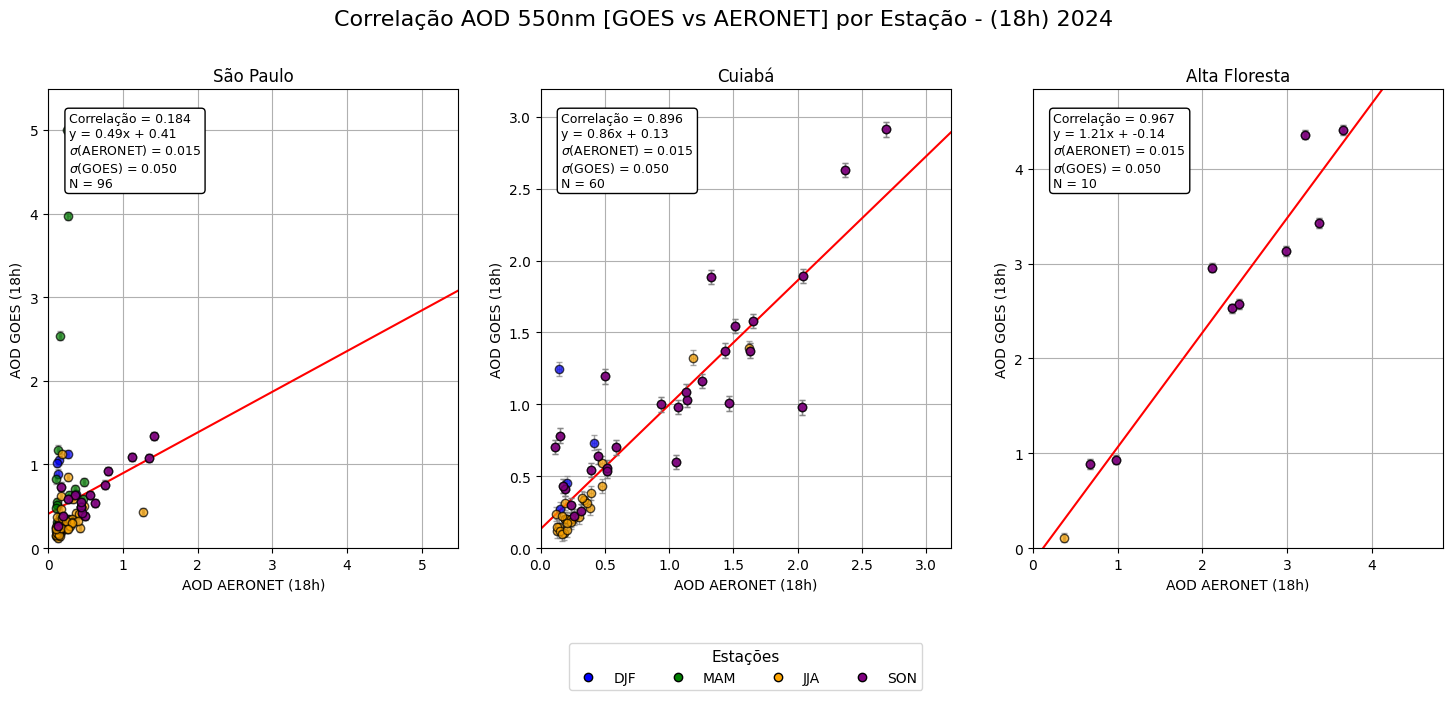

[✓] Figura salva: /content/drive/MyDrive/Meteorologia USP/TCC/correlacoes_imagens/correlacoes_2024_estacoes_com_legenda.png


In [ ]:
#@title Correlação Anual 2024
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# === Função para classificar a estação do ano ===
def estacao_do_ano(data):
    mes = data.month
    if mes in [12, 1, 2]:
        return 'DJF'
    elif mes in [3, 4, 5]:
        return 'MAM'
    elif mes in [6, 7, 8]:
        return 'JJA'
    else:
        return 'SON'

# === Função para processar e gerar dados de cada cidade ===
def processar_cidade(cidade, output_dir):
    arquivo_goes = f'/content/drive/MyDrive/Meteorologia USP/TCC/GOES16 Produto AOD/AOD_GOES16_2024_{cidade}.csv'
    arquivo_aeronet = f'/content/drive/MyDrive/Meteorologia USP/TCC/Aeronet Dados/{cidade}.csv'

    df_goes = pd.read_csv(arquivo_goes)
    df_goes['datetime_aeronet'] = pd.to_datetime(df_goes['data_aeronet'] + ' ' + df_goes['hora_aeronet'])

    col_aod_goes = 'aod'
    df_goes[col_aod_goes] = df_goes[col_aod_goes].astype(str).str.replace(',', '.').astype(float)
    df_goes = df_goes.replace(-999, np.nan)
    df_goes = df_goes[df_goes[col_aod_goes] >= 0.1]

    df_aeronet = pd.read_csv(arquivo_aeronet)
    df_aeronet['datetime'] = pd.to_datetime(
        df_aeronet['Date(dd:mm:yyyy)'] + ' ' + df_aeronet['Time(hh:mm:ss)'],
        format='%d:%m:%Y %H:%M:%S'
    )

    col_aod_aeronet = 'AOD_550nm'
    df_aeronet[col_aod_aeronet] = df_aeronet[col_aod_aeronet].astype(str).str.replace(',', '.').astype(float)
    df_aeronet = df_aeronet.replace(-999, np.nan)
    df_aeronet = df_aeronet[df_aeronet[col_aod_aeronet] >= 0.1]

    matches = []
    for idx, row in df_goes.iterrows():
        dt_aeronet = row['datetime_aeronet']
        aod_goes = row[col_aod_goes]
        df_match = df_aeronet[df_aeronet['datetime'] == dt_aeronet]
        if not df_match.empty:
            for _, aer_row in df_match.iterrows():
                matches.append({
                    'datetime': dt_aeronet,
                    'date': dt_aeronet.date(),
                    'season': estacao_do_ano(dt_aeronet),
                    'AOD_GOES': aod_goes,
                    'AOD_AERONET': aer_row[col_aod_aeronet]
                })

    df_comp = pd.DataFrame(matches)

    output_csv = os.path.join(output_dir, f'AOD_Comparacao_{cidade}_2024.csv')
    df_comp.to_csv(output_csv, index=False)
    print(f'[✓] DataFrame salvo: {output_csv} ({len(df_comp)} pontos)')

    if len(df_comp) >= 2:
        correlacao = df_comp[['AOD_AERONET', 'AOD_GOES']].corr().iloc[0, 1]
        print(f"Correlação para {cidade}: {correlacao:.3f}")
    else:
        correlacao = np.nan
        print(f"Poucos pares para calcular correlação em {cidade}.")

    return df_comp, correlacao

# Diretório
output_dir = '/content/drive/MyDrive/Meteorologia USP/TCC/correlacoes_dados/'
os.makedirs(output_dir, exist_ok=True)

# Cidades
cidades = ['Sao_Paulo', 'CUIABA', 'AltaFloresta']
titulos = ['São Paulo', 'Cuiabá', 'Alta Floresta']

# Cores por estação
season_colors = {'DJF': 'blue', 'MAM': 'green', 'JJA': 'orange', 'SON': 'purple'}

from matplotlib.lines import Line2D
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(18, 8))
gs = GridSpec(2, 3, height_ratios=[6, 1], hspace=0.3)

axes_main = [fig.add_subplot(gs[0, i]) for i in range(3)]
ax_legenda = fig.add_subplot(gs[1, :])
ax_legenda.axis('off')

for ax, cidade, titulo in zip(axes_main, cidades, titulos):
    df_comp, correlacao = processar_cidade(cidade, output_dir)

    legend_handles = []
    for season, cor in season_colors.items():
        dados = df_comp[df_comp['season'] == season]
        if not dados.empty:
            ax.errorbar(dados['AOD_AERONET'], dados['AOD_GOES'],
                        xerr=0.015, yerr=0.05,
                        fmt='o',
                        color=cor, alpha=0.7, ecolor='gray',
                        elinewidth=1, capsize=2, markeredgecolor='k')

            legend_handles.append(Line2D([0], [0], marker='o', color='w',
                                        markerfacecolor=cor, markeredgecolor='k',
                                        label=season, markersize=6))

    # Ajustar limites
    x = df_comp['AOD_AERONET']
    y = df_comp['AOD_GOES']
    valid = ~(x.isna() | y.isna())
    x_valid = x[valid]
    y_valid = y[valid]

    if len(x_valid) > 0:
        min_val = min(x_valid.min(), y_valid.min())
        max_val = max(x_valid.max(), y_valid.max())
        margem = (max_val - min_val) * 0.1
        limite_inf = max(0, min_val - margem)
        limite_sup = max_val + margem
    else:
        limite_inf, limite_sup = 0, 2

    if len(x_valid) > 1:
        m, b = np.polyfit(x_valid, y_valid, 1)
        x_fit = np.array([limite_inf, limite_sup])
        y_fit = m * x_fit + b
        ax.plot(x_fit, y_fit, 'r-', label=f'y = {m:.2f}x + {b:.2f}')
    else:
        m, b = np.nan, np.nan

    ax.set_xlim(limite_inf, limite_sup)
    ax.set_ylim(limite_inf, limite_sup)
    ax.set_xlabel('AOD AERONET (18h)')
    ax.set_ylabel('AOD GOES (18h)')
    ax.set_title(f'{titulo}', fontsize=12)
    ax.grid(True)

    # Texto explicativo com estatísticas
    texto = (f'Correlação = {correlacao:.3f}\n'
             f'y = {m:.2f}x + {b:.2f}\n'
             r'$\sigma$(AERONET) = 0.015' + '\n'
             r'$\sigma$(GOES) = 0.050' + '\n'
             f'N = {len(df_comp)}')

    ax.text(0.05, 0.95, texto,
            transform=ax.transAxes, fontsize=9,
            verticalalignment='top',
            bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))

handles_estacoes = [
    Line2D([0], [0], marker='o', linestyle='', color=color, markeredgecolor='k', label=season)
    for season, color in season_colors.items()
]

ax_legenda.legend(handles=handles_estacoes, title='Estações', loc='center', ncol=4, fontsize=10, title_fontsize=11)

fig.suptitle('Correlação AOD 550nm [GOES vs AERONET] por Estação - (18h) 2024', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Salvar
saida = '/content/drive/MyDrive/Meteorologia USP/TCC/correlacoes_imagens/correlacoes_2024_estacoes_com_legenda.png'
plt.savefig(saida, dpi=300, bbox_inches='tight', transparent=True)
plt.show()
plt.close()
print(f'[✓] Figura salva: {saida}')

[✓] DataFrame salvo: /content/drive/MyDrive/Meteorologia USP/TCC/correlacoes_dados/AOD_Comparacao_Sao_Paulo_2024.csv (88 pontos)
Correlação para Sao_Paulo: 0.687
[✓] DataFrame salvo: /content/drive/MyDrive/Meteorologia USP/TCC/correlacoes_dados/AOD_Comparacao_CUIABA_2024.csv (60 pontos)
Correlação para CUIABA: 0.896
[✓] DataFrame salvo: /content/drive/MyDrive/Meteorologia USP/TCC/correlacoes_dados/AOD_Comparacao_AltaFloresta_2024.csv (10 pontos)
Correlação para AltaFloresta: 0.967


/tmp/ipython-input-30-1539148974.py:170: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])


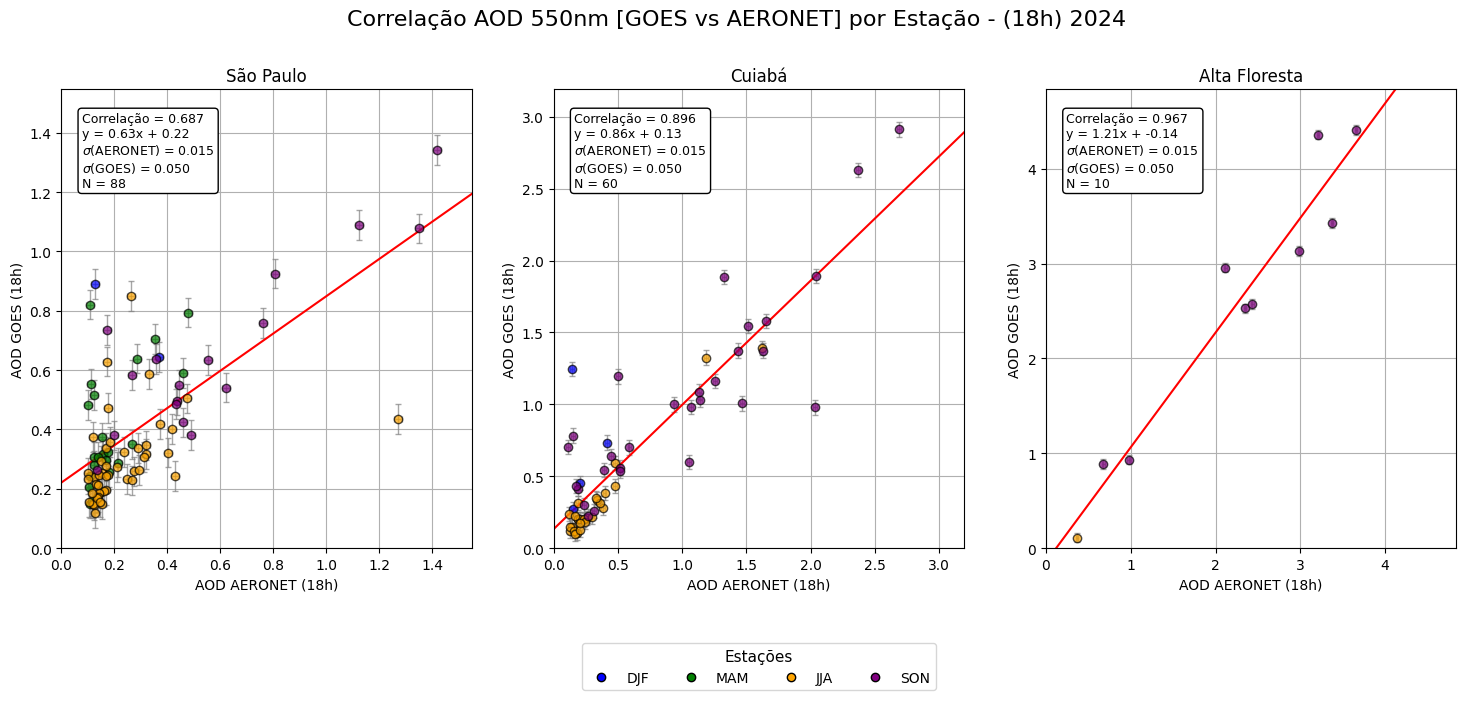

[✓] Figura salva: /content/drive/MyDrive/Meteorologia USP/TCC/correlacoes_imagens/correlacoes_2024_estacoes_com_legenda.png


In [ ]:
#@title Correlação Anual 2024 - Corrigida pra SP (retirando outliers)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# === Função para classificar a estação do ano ===
def estacao_do_ano(data):
    mes = data.month
    if mes in [12, 1, 2]:
        return 'DJF'
    elif mes in [3, 4, 5]:
        return 'MAM'
    elif mes in [6, 7, 8]:
        return 'JJA'
    else:
        return 'SON'

# === Função para processar e gerar dados de cada cidade ===
def processar_cidade(cidade, output_dir):
    arquivo_goes = f'/content/drive/MyDrive/Meteorologia USP/TCC/GOES16 Produto AOD/AOD_GOES16_2024_{cidade}.csv'
    arquivo_aeronet = f'/content/drive/MyDrive/Meteorologia USP/TCC/Aeronet Dados/{cidade}.csv'

    df_goes = pd.read_csv(arquivo_goes)
    df_goes['datetime_aeronet'] = pd.to_datetime(df_goes['data_aeronet'] + ' ' + df_goes['hora_aeronet'])

    col_aod_goes = 'aod'
    df_goes[col_aod_goes] = df_goes[col_aod_goes].astype(str).str.replace(',', '.').astype(float)
    df_goes = df_goes.replace(-999, np.nan)
    df_goes = df_goes[df_goes[col_aod_goes] >= 0.1]

    df_aeronet = pd.read_csv(arquivo_aeronet)
    df_aeronet['datetime'] = pd.to_datetime(
        df_aeronet['Date(dd:mm:yyyy)'] + ' ' + df_aeronet['Time(hh:mm:ss)'],
        format='%d:%m:%Y %H:%M:%S'
    )

    col_aod_aeronet = 'AOD_550nm'
    df_aeronet[col_aod_aeronet] = df_aeronet[col_aod_aeronet].astype(str).str.replace(',', '.').astype(float)
    df_aeronet = df_aeronet.replace(-999, np.nan)
    df_aeronet = df_aeronet[df_aeronet[col_aod_aeronet] >= 0.1]

    matches = []
    for idx, row in df_goes.iterrows():
        dt_aeronet = row['datetime_aeronet']
        aod_goes = row[col_aod_goes]
        df_match = df_aeronet[df_aeronet['datetime'] == dt_aeronet]
        if not df_match.empty:
            for _, aer_row in df_match.iterrows():
                matches.append({
                    'datetime': dt_aeronet,
                    'date': dt_aeronet.date(),
                    'season': estacao_do_ano(dt_aeronet),
                    'AOD_GOES': aod_goes,
                    'AOD_AERONET': aer_row[col_aod_aeronet]
                })

    df_comp = pd.DataFrame(matches)


    # === Remover datas específicas para São Paulo ===
    if cidade == 'Sao_Paulo':
        datas_remover = ['2024-01-06', '2024-01-30', '2024-03-07', '2024-03-21',
                         '2024-04-09', '2024-05-22', '2024-07-06', '2024-12-12']
        datas_remover = pd.to_datetime(datas_remover).date
        df_comp = df_comp[~df_comp['date'].isin(datas_remover)]

    output_csv = os.path.join(output_dir, f'AOD_Comparacao_{cidade}_2024.csv')
    df_comp.to_csv(output_csv, index=False)
    print(f'[✓] DataFrame salvo: {output_csv} ({len(df_comp)} pontos)')

    if len(df_comp) >= 2:
        correlacao = df_comp[['AOD_AERONET', 'AOD_GOES']].corr().iloc[0, 1]
        print(f"Correlação para {cidade}: {correlacao:.3f}")
    else:
        correlacao = np.nan
        print(f"Poucos pares para calcular correlação em {cidade}.")

    return df_comp, correlacao

# Diretório
output_dir = '/content/drive/MyDrive/Meteorologia USP/TCC/correlacoes_dados/'
os.makedirs(output_dir, exist_ok=True)

# Cidades
cidades = ['Sao_Paulo', 'CUIABA', 'AltaFloresta']
titulos = ['São Paulo', 'Cuiabá', 'Alta Floresta']

# Cores por estação
season_colors = {'DJF': 'blue', 'MAM': 'green', 'JJA': 'orange', 'SON': 'purple'}

from matplotlib.lines import Line2D
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(18, 8))
gs = GridSpec(2, 3, height_ratios=[6, 1], hspace=0.3)

axes_main = [fig.add_subplot(gs[0, i]) for i in range(3)]
ax_legenda = fig.add_subplot(gs[1, :])
ax_legenda.axis('off')

for ax, cidade, titulo in zip(axes_main, cidades, titulos):
    df_comp, correlacao = processar_cidade(cidade, output_dir)

    legend_handles = []
    for season, cor in season_colors.items():
        dados = df_comp[df_comp['season'] == season]
        if not dados.empty:
            ax.errorbar(dados['AOD_AERONET'], dados['AOD_GOES'],
                        xerr=0.015, yerr=0.05,
                        fmt='o',
                        color=cor, alpha=0.7, ecolor='gray',
                        elinewidth=1, capsize=2, markeredgecolor='k')

            legend_handles.append(Line2D([0], [0], marker='o', color='w',
                                        markerfacecolor=cor, markeredgecolor='k',
                                        label=season, markersize=6))

    # Ajustar limites
    x = df_comp['AOD_AERONET']
    y = df_comp['AOD_GOES']
    valid = ~(x.isna() | y.isna())
    x_valid = x[valid]
    y_valid = y[valid]

    if len(x_valid) > 0:
        min_val = min(x_valid.min(), y_valid.min())
        max_val = max(x_valid.max(), y_valid.max())
        margem = (max_val - min_val) * 0.1
        limite_inf = max(0, min_val - margem)
        limite_sup = max_val + margem
    else:
        limite_inf, limite_sup = 0, 2

    if len(x_valid) > 1:
        m, b = np.polyfit(x_valid, y_valid, 1)
        x_fit = np.array([limite_inf, limite_sup])
        y_fit = m * x_fit + b
        ax.plot(x_fit, y_fit, 'r-', label=f'y = {m:.2f}x + {b:.2f}')
    else:
        m, b = np.nan, np.nan

    ax.set_xlim(limite_inf, limite_sup)
    ax.set_ylim(limite_inf, limite_sup)
    ax.set_xlabel('AOD AERONET (18h)')
    ax.set_ylabel('AOD GOES (18h)')
    ax.set_title(f'{titulo}', fontsize=12)
    ax.grid(True)

    # Texto explicativo com estatísticas
    texto = (f'Correlação = {correlacao:.3f}\n'
             f'y = {m:.2f}x + {b:.2f}\n'
             r'$\sigma$(AERONET) = 0.015' + '\n'
             r'$\sigma$(GOES) = 0.050' + '\n'
             f'N = {len(df_comp)}')

    ax.text(0.05, 0.95, texto,
            transform=ax.transAxes, fontsize=9,
            verticalalignment='top',
            bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))

handles_estacoes = [
    Line2D([0], [0], marker='o', linestyle='', color=color, markeredgecolor='k', label=season)
    for season, color in season_colors.items()
]

ax_legenda.legend(handles=handles_estacoes, title='Estações', loc='center', ncol=4, fontsize=10, title_fontsize=11)

fig.suptitle('Correlação AOD 550nm [GOES vs AERONET] por Estação - (18h) 2024', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Salvar
saida = '/content/drive/MyDrive/Meteorologia USP/TCC/correlacoes_imagens/correlacoes_2024_estacoes_com_legenda.png'
plt.savefig(saida, dpi=300, bbox_inches='tight', transparent=True)
plt.show()
plt.close()
print(f'[✓] Figura salva: {saida}')

Qtd de pontos: 351
Correlação entre AOD AERONET e AOD GOES: 0.867


/tmp/ipython-input-60-3653200785.py:58: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', len(unique_dates))


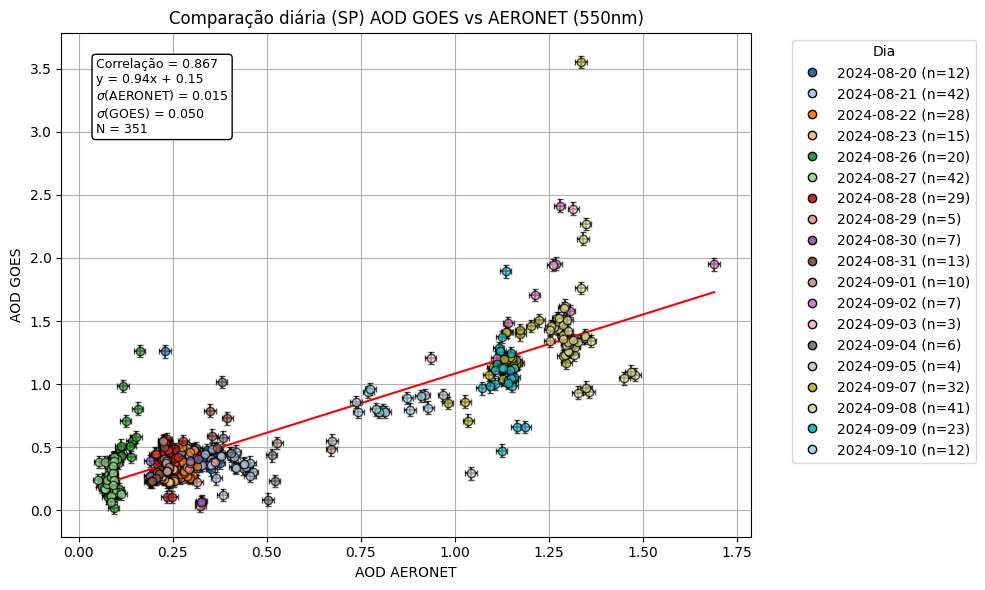

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from matplotlib.lines import Line2D

# === Arquivos ===
arquivo_goes = '/content/drive/MyDrive/Meteorologia USP/TCC/GOES16 Produto AOD/AOD_GOES16_Sao_Paulo_final.csv'
arquivo_aeronet = '/content/drive/MyDrive/Meteorologia USP/TCC/Aeronet Dados/Sao_Paulo.csv'

# === Ler GOES ===
df_goes = pd.read_csv(arquivo_goes)
df_goes['datetime_aeronet'] = pd.to_datetime(df_goes['data_aeronet'] + ' ' + df_goes['hora_aeronet'])
col_aod_goes = 'aod_goes'
df_goes[col_aod_goes] = df_goes[col_aod_goes].astype(str).str.replace(',', '.').astype(float)
df_goes = df_goes.replace(-999, np.nan)
df_goes = df_goes[df_goes[col_aod_goes].between(0, 5)]

# === Ler AERONET ===
df_aeronet = pd.read_csv(arquivo_aeronet)
df_aeronet['datetime'] = pd.to_datetime(df_aeronet['Date(dd:mm:yyyy)'] + ' ' + df_aeronet['Time(hh:mm:ss)'], format='%d:%m:%Y %H:%M:%S')
col_aod_aeronet = 'AOD_550nm'
df_aeronet[col_aod_aeronet] = df_aeronet[col_aod_aeronet].astype(str).str.replace(',', '.').astype(float)
df_aeronet = df_aeronet.replace(-999, np.nan)
df_aeronet = df_aeronet[df_aeronet[col_aod_aeronet].between(0, 5)]

# === Matching ===
matches = []
for idx, row in df_goes.iterrows():
    dt_aeronet = row['datetime_aeronet']
    aod_goes = row[col_aod_goes]
    df_match = df_aeronet[df_aeronet['datetime'] == dt_aeronet]
    if not df_match.empty:
        for _, aer_row in df_match.iterrows():
            matches.append({
                'datetime': dt_aeronet,
                'date': dt_aeronet.date(),
                'AOD_GOES': aod_goes,
                'AOD_AERONET': aer_row[col_aod_aeronet]
            })

df_comp = pd.DataFrame(matches)

print(f'Qtd de pontos: {len(df_comp)}')

if len(df_comp) >= 2:
    correlacao = df_comp[['AOD_AERONET', 'AOD_GOES']].corr().iloc[0, 1]
    print(f"Correlação entre AOD AERONET e AOD GOES: {correlacao:.3f}")
else:
    correlacao = np.nan
    print("Poucos pares para calcular correlação.")

# === Plot ===
plt.figure(figsize=(10, 6))

# Definir cores por data
unique_dates = sorted(df_comp['date'].unique())
colors = plt.cm.get_cmap('tab20', len(unique_dates))
date_color_dict = {date: colors(i) for i, date in enumerate(unique_dates)}

# Valores fixos para barras de erro
xerr_fixed = 0.015  # Desvio padrão fixo para AERONET
yerr_fixed = 0.050  # Desvio padrão fixo para GOES

# Plotar pontos com barras de erro por data
for date in unique_dates:
    subset = df_comp[df_comp['date'] == date]
    if not subset.empty:
        # Usar todos os pontos do subset para errorbar
        plt.errorbar(subset['AOD_AERONET'], subset['AOD_GOES'],
                     xerr=xerr_fixed, yerr=yerr_fixed,
                     fmt='o', ecolor='black',color=date_color_dict[date], alpha=0.7, capsize=2,
                     markeredgecolor='k', label=f"{date.strftime('%Y-%m-%d')}")

# Reta de ajuste
X = df_comp[['AOD_AERONET']].values
y = df_comp['AOD_GOES'].values
model = LinearRegression()
model.fit(X, y)
m = model.coef_[0]  # Inclinação
b = model.intercept_  # Intercepto
x_fit = np.linspace(df_comp['AOD_AERONET'].min(), df_comp['AOD_AERONET'].max(), 100)
y_fit = model.predict(x_fit.reshape(-1, 1))
plt.plot(x_fit, y_fit, 'r-', label=f'y = {m:.2f}x + {b:.2f}')

# Texto explicativo com estatísticas
texto = (f'Correlação = {correlacao:.3f}\n'
         f'y = {m:.2f}x + {b:.2f}\n'
         r'$\sigma$(AERONET) = 0.015' + '\n'
         r'$\sigma$(GOES) = 0.050' + '\n'
         f'N = {len(df_comp)}')
plt.text(0.05, 0.95, texto,
         transform=plt.gca().transAxes, fontsize=9,
         verticalalignment='top',
         bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))

plt.xlabel('AOD AERONET')
plt.ylabel('AOD GOES')
plt.title('Comparação diária (SP) AOD GOES vs AERONET (550nm)')
plt.grid(True)

# Legenda com datas
handles = []
for date in unique_dates:
    subset = df_comp[df_comp['date'] == date]
    n_points = len(subset)
    handles.append(Line2D([0], [0], marker='o', color='w', markerfacecolor=date_color_dict[date], markeredgecolor='k',
                          label=f"{date.strftime('%Y-%m-%d')} (n={n_points})"))
plt.legend(handles=handles, title='Dia', bbox_to_anchor=(1.05, 1), loc='upper left', ncol=1)

plt.tight_layout()
saida = '/content/drive/MyDrive/Meteorologia USP/TCC/correlacoes_imagens/correlacoes_finaissp.png'
plt.savefig(saida, dpi=300, bbox_inches='tight', transparent=True)
plt.show()

Qtd de pontos: 351
Bias: 0.1107
MAE: 0.1760
RMSE: 0.2746
R²: 0.6479
MBE%: 61.01%
MAPE: 70.79%


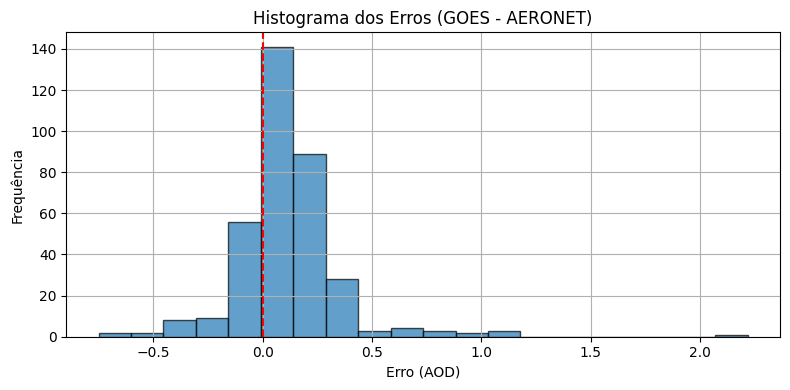

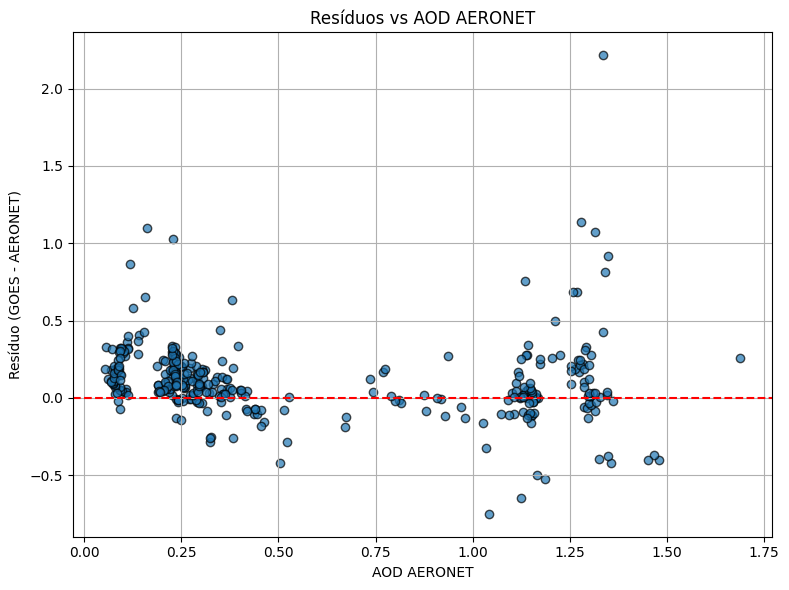

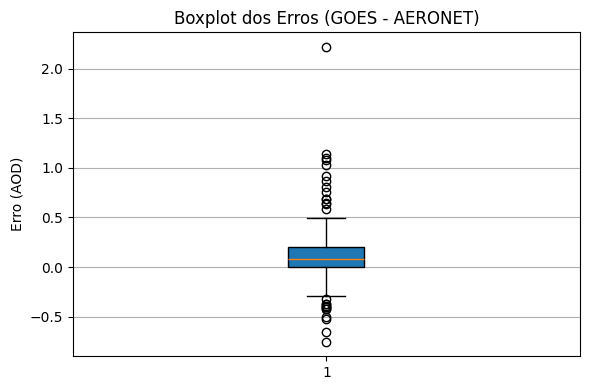

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# === Diferenças ===
df_comp['erro'] = df_comp['AOD_GOES'] - df_comp['AOD_AERONET']
df_comp['erro_relativo'] = df_comp['erro'] / df_comp['AOD_AERONET']

# === Métricas ===
n = len(df_comp)
bias = df_comp['erro'].mean()
mae = df_comp['erro'].abs().mean()
mse = (df_comp['erro']**2).mean()
rmse = np.sqrt(mse)

# Coeficiente de Determinação (R²)
from sklearn.metrics import r2_score
r2 = r2_score(df_comp['AOD_AERONET'], df_comp['AOD_GOES'])

# Erros Percentuais
# Evita divisões por zero
df_comp = df_comp[df_comp['AOD_AERONET'] != 0]
mbe_percent = (df_comp['erro_relativo'].mean()) * 100
mape = (df_comp['erro_relativo'].abs().mean()) * 100

# === Exibir métricas ===
print(f'Qtd de pontos: {n}')
print(f'Bias: {bias:.4f}')
print(f'MAE: {mae:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'R²: {r2:.4f}')
print(f'MBE%: {mbe_percent:.2f}%')
print(f'MAPE: {mape:.2f}%')

# === Gráficos adicionais ===

# 1. Histograma dos erros
plt.figure(figsize=(8,4))
plt.hist(df_comp['erro'], bins=20, edgecolor='k', alpha=0.7)
plt.axvline(0, color='red', linestyle='--')
plt.title('Histograma dos Erros (GOES - AERONET)')
plt.xlabel('Erro (AOD)')
plt.ylabel('Frequência')
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. Gráfico de dispersão dos resíduos
plt.figure(figsize=(8,6))
plt.scatter(df_comp['AOD_AERONET'], df_comp['erro'], alpha=0.7, edgecolors='k')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('AOD AERONET')
plt.ylabel('Resíduo (GOES - AERONET)')
plt.title('Resíduos vs AOD AERONET')
plt.grid(True)
plt.tight_layout()
plt.show()

# 3. Boxplot dos erros
plt.figure(figsize=(6,4))
plt.boxplot(df_comp['erro'], vert=True, patch_artist=True)
plt.title('Boxplot dos Erros (GOES - AERONET)')
plt.ylabel('Erro (AOD)')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


In [ ]:
#@title Download dados específicos - OUTLIERS
import os
import boto3
from botocore import UNSIGNED
from botocore.config import Config
from datetime import datetime

# Função para baixar arquivo
def download_file(s3, bucket_name, s3_key, local_file):
    try:
        s3.download_file(bucket_name, s3_key, local_file)
        print(f"Baixado: {local_file}")
        return True
    except Exception as e:
        print(f"Erro ao baixar {s3_key}: {e}")
        return False

# Lista de datas e horários específicos
target_datetimes = [
    "2024-01-06 18",
    "2024-01-30 18",
    "2024-03-07 18",
    "2024-03-21 17",
    "2024-04-09 18",
    "2024-05-22 19",
    "2024-07-06 18",
    "2024-12-12 18"
]

# Configurações
input_dir = "./samples"
os.makedirs(input_dir, exist_ok=True)

s3 = boto3.client('s3', config=Config(signature_version=UNSIGNED))
bucket_name = 'noaa-goes16'
product = 'ABI-L2-AODF'

# Loop pelos momentos específicos
for dt_str in target_datetimes:
    dt = datetime.strptime(dt_str, "%Y-%m-%d %H")
    y = dt.strftime('%Y')
    j = dt.strftime('%j')
    h = dt.strftime('%H')

    prefix = f"{product}/{y}/{j}/{h}/"

    try:
        response = s3.list_objects_v2(Bucket=bucket_name, Prefix=prefix)
        if 'Contents' not in response:
            print(f"Nenhum arquivo encontrado para {prefix}")
            continue

        target_time_str = dt.strftime("s%Y%j%H%M")  # Formato parcial para identificar o início do nome do arquivo
        found = False
        for obj in response['Contents']:
            key = obj['Key']
            if target_time_str in key:
                filename = os.path.join(input_dir, os.path.basename(key))
                if not os.path.exists(filename):
                    if download_file(s3, bucket_name, key, filename):
                        found = True
                else:
                    print(f"Já existe: {filename}")
                    found = True

        if not found:
            print(f"Arquivo com hora exata {dt_str} não encontrado em {prefix}")

    except Exception as e:
        print(f"Erro ao processar {dt_str}: {e}")

print("Download concluído.")


Já existe: ./samples/OR_ABI-L2-AODF-M6_G16_s20240061800188_e20240061809496_c20240061811121.nc
Já existe: ./samples/OR_ABI-L2-AODF-M6_G16_s20240301800206_e20240301809514_c20240301811288.nc
Já existe: ./samples/OR_ABI-L2-AODF-M6_G16_s20240671800203_e20240671809511_c20240671814262.nc
Já existe: ./samples/OR_ABI-L2-AODF-M6_G16_s20240811700187_e20240811709495_c20240811714398.nc
Já existe: ./samples/OR_ABI-L2-AODF-M6_G16_s20241001800204_e20241001809512_c20241001814309.nc
Já existe: ./samples/OR_ABI-L2-AODF-M6_G16_s20241431900208_e20241431909516_c20241431914354.nc
Já existe: ./samples/OR_ABI-L2-AODF-M6_G16_s20241881800221_e20241881809529_c20241881814413.nc
Já existe: ./samples/OR_ABI-L2-AODF-M6_G16_s20243471800204_e20243471809512_c20243471814446.nc
Download concluído.
